# Config

### Imports

In [1]:
import itertools
import os
import random
import shutil
import time
from tqdm.notebook import tqdm
import uuid
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Constants

In [3]:
TRAIN_ON_TF = 'TF_2'
TRAIN_PROBE = 'A'
TEST_PROBE = 'B'
MOTIF_LEN = 32
NUM_MOTIF_DETECTORS=16
BATCH_SIZE = 64

In [4]:
DNA_BASES = 'ACGT'
RNA_BASES = 'ACGU'

In [5]:
PBM_DATA = "./data/dream5/pbm"

### Make training deterministic

In [6]:
def set_global_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
set_global_seed(42)

# Data preparation

### Read DREAM5 sequence data with binding scores

In [8]:
df_seq = pd.read_csv(f"{PBM_DATA}/sequences.tsv", sep='\t')
df_seq.head()

,Fold ID,Event ID,seq
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT


In [9]:
df_targets = pd.read_csv(f"{PBM_DATA}/targets.tsv", sep='\t')
df_targets.head()

,TF_40,TF_41,TF_42,TF_43,TF_44,TF_45,TF_46,TF_47,TF_48,TF_49,...,C_19,C_18,C_15,C_14,C_17,C_16,C_11,C_10,C_13,C_12
0,823.914118,12702.625538,2124.023125,2314.305782,1474.888697,1131.785521,4597.003319,14589.890994,1556.951404,34180.775942,...,1651.254953,1242.303363,724.105850,3184.883349,8935.394363,12689.558779,4102.312624,505.126184,12946.381724,1313.790253
1,1307.840222,4316.426121,2554.658908,3415.320661,3408.586803,1697.342725,5272.763446,22903.130555,2181.551097,10000.297243,...,3505.604759,2516.000120,1640.114829,3463.713253,19535.468264,18006.721690,6890.427794,1402.597000,38309.856355,3024.107809
2,1188.353499,3436.803941,2088.909658,3708.324021,2219.741833,1571.646567,6225.376501,13858.014077,1971.053716,18800.025304,...,3270.572883,1693.419147,997.792996,3196.992198,16695.027604,14486.992627,13517.968701,10680.866586,25648.825592,2675.530918
3,1806.103795,6531.268855,2406.186212,3601.204703,2828.415329,2746.861783,5810.104650,25701.749693,2191.273065,19213.880658,...,2701.555739,2059.614815,1432.163042,4927.163643,18896.765835,18784.043322,8608.167421,4624.044391,23651.726053,3679.449867
4,1417.411525,3951.243575,2581.309532,3375.884699,2764.716964,1806.919566,5033.976283,26364.859152,2311.790793,16139.097553,...,2457.214141,1901.709222,1672.531034,3877.787322,14699.253953,17119.871513,8995.328144,12641.425965,27999.405431,3128.844808


### Build a dataframe for single transcription factor

In [10]:
def build_df(tf, df_seq, df_targets):
    df = df_seq.copy()
    df["Target"] = df_targets[tf].values
    return df

In [11]:
df = build_df(TRAIN_ON_TF, df_seq, df_targets)
df.head()

,Fold ID,Event ID,seq,Target
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598


### Remove probe specific biases for each sequence

In [12]:
biases = df_targets.median(axis=1).values
biases

array([2641.988164 , 4170.2475   , 3699.8877625, ..., 2287.3149815,
       1884.915039 , 1231.9427485], shape=(80856,))

In [13]:
# Note this won't cause data leak because then normalization is sequence specific and does not use other sequences
df['TargetNorm'] = df['Target'].values / biases
df.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


### Calculate NA content and drop rows

In [14]:
# Only 4% NA content, it is safe to drop the rows
df['Target'].isna().mean()

np.float64(0.04049173839912932)

In [15]:
df.dropna(subset=['Target'], inplace=True)
df['Target'].isna().mean()

np.float64(0.0)

### Train/Test data split

In [16]:
df_train = df[df['Fold ID'] == TRAIN_PROBE]
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426


In [17]:
df_test = df[df['Fold ID'] == TEST_PROBE]
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


In [18]:
df_train.shape, df_test.shape

((38041, 5), (39541, 5))

### Add labels for ROC and AUC

In [19]:
# DREAM5 https://pmc.ncbi.nlm.nih.gov/articles/PMC3687085/
def add_label(d):
    # Add positive label to only rows with binding score higher than mean + 4*std
    mean = d['Target'].mean()
    std = d['Target'].std()
    lower_limit = mean + 4*std

    # Limits MAX: 1300 rows MIN: 50 rows
    top = d[d['Target'] > lower_limit].copy()
    if len(top) >= 50:
        top = top.sort_values(by='Target', ascending=False).head(1300)
    else:
        top = d.sort_values(by='Target', ascending=False, inplace=False).head(50)

    d['Label'] = 0
    d.loc[top.index, 'Label'] = 1

In [20]:
add_label(df_train)
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724,0
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000,0
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750,0
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457,0
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426,0


In [21]:
df_train[df_train['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40545,A,HK37117,ATAGATGATTGCCTAATAGAACCTACACAGTAAACCCTGT,23505.012865,6.751061,1
40630,A,HK39222,AGGTGTTACATATATCAGCTTGGGTGGATACCCGACCTGT,19403.494948,7.323275,1
40751,A,HK31683,GGCATTCAGGACAATTAGATAACCCAAGCGTAGCCCCTGT,20245.802138,8.385751,1
40775,A,HK34305,TGTATTGCATAAACGTTCCAGGACCCCTGGCTCACCCTGT,33224.921774,14.948550,1
40961,A,HK15380,TGTATGATCACCAACTCATGGTTGCGCAATGAACCCCTGT,22591.018693,7.530934,1


In [22]:
add_label(df_test)
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377,0
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671,0
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141,0
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181,0
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512,0


In [23]:
df_test[df_test['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
149,B,MEforward05359,TAAGAAAAGATTTTTACGTAACATGTCTACTCTGGCCTGT,54999.072022,15.626592,1
598,B,MEreverse19582,ATCGAGTCGGCTTTACAATTACATAATCTAAGCTACCTGT,72179.964196,10.621469,1
640,B,MEforward05965,AGCTACATGTAGCTCGGCATTTATATAACCCACTGCCTGT,26433.473625,5.848461,1
769,B,MEreverse06558,ATTCTAACGACTGTGACATAATGACCCCACCTCGGCCTGT,28221.317418,5.393725,1
825,B,MEreverse08764,TACGCATTTACGTTGCATAATCTTGTGAGTAGCAGCCTGT,54040.187164,10.802248,1


### Mathmatical target normalization to N(0, 1)

In [24]:
# target_norm = df_train['TargetNorm'].values
# df_train['TargetNormFinal'] = (target_norm - target_norm.mean()) / target_norm.std()
# df_train.head()

In [25]:
# target_norm = df_test['TargetNorm'].values
# df_test['TargetNormFinal'] = (target_norm - target_norm.mean()) / target_norm.std()
# df_test.head()

### DNA/RNA sequence to Matrix logic

In [26]:
def fill_cell(motif_len, row, col, bases, seq):
    num_rows = len(seq) + 2 * motif_len - 2
    
    # First M-1 rows are filled with 0.25
    if row < motif_len-1:
        return 0.25

    # Last M-1 rows are filled with 0.25
    if num_rows-1-row < motif_len-1:
        return 0.25

    idx = row - motif_len + 1
    if seq[idx] == bases[col]:
        return 1.0

    return 0.0

def seq2matrix(seq, motif_len, typ='DNA'):
    bases = DNA_BASES if typ == 'DNA' else RNA_BASES
    num_rows = len(seq) + 2 * motif_len - 2
    result = np.empty([num_rows, 4])
    for row in range(num_rows):
        for col in range(4):
            result[row, col] = fill_cell(motif_len, row, col, bases, seq)
    return np.transpose(result)

In [27]:
# Test the function
S = seq2matrix("ATGG", 3, 'DNA')
S

array([[0.25, 0.25, 1.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 1.  , 1.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 1.  , 0.  , 0.  , 0.25, 0.25]])

In [28]:
S.shape

(4, 8)

### Train Data Augmentation (Reverse Complement)

In [29]:
def reverse_complement_batch(x):
    # x: (B, 4, L)
    # reverse the sequence
    x = torch.flip(x, dims=[2])
    
    # swap A-T, C-G
    # A C G T → T G C A
    x = x[:, [3, 2, 1, 0], :]

    return x

def reverse_complement_M(x):
    # x: (4, L)
    # reverse the sequence
    x = torch.flip(x, dims=[1])
    
    # swap A-T, C-G
    # A C G T → T G C A
    x = x[[3, 2, 1, 0], :]

    return x

### Sequence Dataset and Loader

In [30]:
class SeqDataset(Dataset):
    def __init__(self, df, augment=False):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values
        self.aug = augment

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        
        M = seq2matrix(seq, MOTIF_LEN, 'DNA')
        
        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        # Augment the data
        if self.aug and random.random() > 0.5:
            x = reverse_complement_M(x)
        
        return x, y, label

In [31]:
train_dataset = SeqDataset(df_train, augment=True)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [32]:
xs, ys, labels = [], [], []

for x, y, label in train_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_train = torch.stack(xs)
y_train = torch.tensor(ys, dtype=torch.float32)
label_train = torch.tensor(labels)

In [33]:
x, target, label = next(iter(train_loader))
x.shape, target.shape, label.shape

(torch.Size([64, 4, 102]), torch.Size([64]), torch.Size([64]))

In [34]:
# Do NOT augment test dataset
test_dataset = SeqDataset(df_test, augment=False)

xs, ys, labels = [], [], []

for x, y, label in test_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_test = torch.stack(xs)
y_test = torch.tensor(ys, dtype=torch.float32)
label_test = torch.tensor(labels)

In [35]:
x_test.shape, y_test.shape, label_test.shape

(torch.Size([39541, 4, 102]), torch.Size([39541]), torch.Size([39541]))

# Model

### DeepBind Model

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DeepBindShallow(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.5):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc1 = nn.Linear(num_motif_detectors, 1)
        
        self.init_weights()

    def init_weights(self):
        init.normal_(self.conv.weight, mean=0.0, std=0.001)
        init.constant_(self.conv.bias, 0.0)

        init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        init.constant_(self.fc1.bias, 0.0)
        
    def forward_pass(self, x):
        
        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc1(x)

        return x

    def forward(self, x):
        r = self.forward_pass(x)
        
        x_comp = reverse_complement_batch(x)
        r_comp = self.forward_pass(x_comp)
        
        r_final = torch.max(r, r_comp)
        
        return r_final

In [37]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DeepBind(nn.Module):
    def __init__(self, 
                 num_motif_detectors, 
                 motif_len,
                 dropout,
                 conv_init_w,
                 fc_init_w):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc1 = nn.Linear(num_motif_detectors, 32)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(32, 1)

        self.init_weights(conv_init_w, fc_init_w)

    def init_weights(self, conv_init_w, fc_init_w):
        init.normal_(self.conv.weight, mean=0.0, std=conv_init_w)
        init.constant_(self.conv.bias, 0.0)

        init.normal_(self.fc1.weight, mean=0.0, std=fc_init_w)
        init.constant_(self.fc1.bias, 0.0)
        
        init.normal_(self.fc2.weight, mean=0.0, std=fc_init_w)
        init.constant_(self.fc2.bias, 0.0)

    def forward_pass(self, x):
        
        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def forward(self, x):
        r = self.forward_pass(x)
        
        x_comp = reverse_complement_batch(x)
        r_comp = self.forward_pass(x_comp)
        
        r_final = torch.max(r, r_comp)
        
        return r_final

### Model Wrapper for training

In [38]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class ModelWrapper:
    def __init__(self, m, lr=1e-3, w_decay=1e-3):
        self.model = m.to(DEVICE)
        #self.opt = torch.optim.Adam(self.model.parameters(), lr=0.0005)
        self.opt = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=w_decay)
        self.criterion = torch.nn.MSELoss()

    def train_step(self, x, target):
        self.model.train()
        
        x = x.to(DEVICE)
        target = target.to(DEVICE)

        self.opt.zero_grad()

        pred = self.model(x)
        loss = self.criterion(pred.squeeze(), target)

        loss.backward()
        self.opt.step()
        
        return loss.item()

    def predict(self, x):
        self.model.eval()
        x = x.to(DEVICE)
        pred = self.model(x).squeeze()
        pred = pred.detach().cpu().numpy()
        return pred

    def evaluate(self, x, y_true, label_true):
        y_pred = self.predict(x)

        fpr, tpr, thresholds = roc_curve(label_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        pearson_corr, _ = pearsonr(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)

        # plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        # plt.plot([0, 1], [0, 1], linestyle='--')
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.legend()
        # plt.show()

        return {
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'auc': roc_auc,
        }

    def train_one_epoch(self, loader):
        epoch_loss = 0
        for i, (x, y, label) in enumerate(tqdm(loader)):
            epoch_loss += self.train_step(x, y)
        epoch_loss = epoch_loss / len(loader)
        return epoch_loss

### Sanity Check: Overfit on single mini-batch

In [39]:
x, y, label = next(iter(train_loader))
x.shape, y.shape, label.shape

(torch.Size([64, 4, 102]), torch.Size([64]), torch.Size([64]))

In [40]:
m_sanity = DeepBindShallow(num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN)

In [41]:
mw_sanity = ModelWrapper(m_sanity)

In [42]:
for i in range(10000):
    loss = mw_sanity.train_step(x, y)
    if i % 1000 == 0:
        print(loss)

1.459503173828125
9.338020356963739e-10
2.2161972257350726e-10
7.377842781153277e-11
2.6953286824671352e-11
9.788447830061386e-12
3.5474956305847627e-12
6.467210100780107e-11
6.387113060668526e-13
8.125923267598978e-10


In [43]:
pred_sanity = mw_sanity.predict(x)
pred_sanity[:10]

array([0.7137316 , 1.0000083 , 0.79075855, 0.6224653 , 0.62643313,
       0.89629555, 1.0121232 , 0.73385614, 0.74463826, 0.61047417],
      dtype=float32)

In [44]:
target_sanity = y.cpu().numpy()
target_sanity[:10]

array([0.71372354, 1.        , 0.7907503 , 0.6224574 , 0.6264257 ,
       0.89628714, 1.0121148 , 0.7338479 , 0.7446303 , 0.61046606],
      dtype=float32)

In [45]:
for name, p in mw_sanity.model.named_parameters():
    print(name, p.data.abs().mean().item())

conv.weight 0.06273366510868073
conv.bias 0.00629928894340992
fc1.weight 0.08950205147266388
fc1.bias 0.027067001909017563


### Sanity Check: Reverse compliment

In [46]:
np.allclose(mw_sanity.predict(x), mw_sanity.predict(reverse_complement_batch(reverse_complement_batch(x))))

True

# Training

In [47]:
import os

def save_snapshot(mw, epoch, params):
    snap_path = "/tmp/snaps"
    os.makedirs(snap_path, exist_ok=True)
    name = f"{snap_path}/model_epoch_{epoch}.pt"
    torch.save({
        "model": mw.model.state_dict(),
        "params": params,
    }, name)
    return name

def load_snapshot(path):
    ckpt = torch.load(path, map_location="cpu")
    params = ckpt["params"]
    print(params)

    m = DeepBind(
        num_motif_detectors=params['num_motif_detectors'],
        motif_len=params['motif_len'],
        dropout=params['dropout'],
        conv_init_w=params['conv_init_weight_std'],
        fc_init_w=params['fc_init_weight_std'],
    )
    mw = ModelWrapper(m, lr=params['lr'], w_decay=params['weight_decay'])
    
    mw.model.load_state_dict(ckpt["model"])

    return mw

In [48]:
import wandb

def train_wandb(run_name, mw, loader, epochs, params):
    run = wandb.init(
        entity="vvaza22-free-university-of-tbilisi",
        project="CompBioFinal",
        name=run_name,
        config={
            "model": "DeepBind",
            "dataset": "DREAM5",
            "epochs": epochs,
            **params
        },
    )

    for epoch in range(1, epochs+1):
        print(f"===== EPOCH {epoch} =====")
        epoch_loss = mw.train_one_epoch(loader)
        print(f"Loss: {epoch_loss}")

        metrics_train = mw.evaluate(x_train, y_train, label_train)
        metrics_test = mw.evaluate(x_test, y_test, label_test)
        
        wandb.log({
            'epoch_loss': epoch_loss,
            'train/pearson': metrics_train['pearson'],
            'train/spearman': metrics_train['spearman'],
            'train/auc': metrics_train['auc'],
            'test/pearson': metrics_test['pearson'],
            'test/spearman': metrics_test['spearman'],
            'test/auc': metrics_test['auc'],
        }, step=epoch)

    run.finish()

In [49]:
import wandb

MIN_DELTA = 1e-3

def early_stopping_train_wandb(run_name, mw, loader, epochs, params):
    run = wandb.init(
        entity="vvaza22-free-university-of-tbilisi",
        project="CompBioFinal",
        name=run_name,
        config={
            "model": "DeepBind",
            "dataset": "DREAM5",
            "epochs": epochs,
            "tf": TRAIN_ON_TF,
            **params
        },
    )

    best_test_pearson = 0

    for epoch in range(1, epochs+1):
        print(f"===== EPOCH {epoch} =====")
        epoch_loss = mw.train_one_epoch(loader)
        print(f"Loss: {epoch_loss}")

        metrics_train = mw.evaluate(x_train, y_train, label_train)
        metrics_test = mw.evaluate(x_test, y_test, label_test)

        results = {
            'epoch_loss': epoch_loss,
            'train/pearson': metrics_train['pearson'],
            'train/spearman': metrics_train['spearman'],
            'train/auc': metrics_train['auc'],
            'test/pearson': metrics_test['pearson'],
            'test/spearman': metrics_test['spearman'],
            'test/auc': metrics_test['auc'],
        }
        print(results)

        # Snapshot the model
        snap = save_snapshot(mw, epoch, params)
        artifact = wandb.Artifact(
            name=f"model_epoch_{epoch}",
            type="model"
        )
        artifact.add_file(snap)
        wandb.log_artifact(artifact)
        
        wandb.log(results, step=epoch)

        if metrics_test['pearson'] > best_test_pearson:
            best_test_pearson = metrics_test['pearson']
        elif metrics_test['pearson'] + MIN_DELTA < best_test_pearson:
            # Overfitting
            print(f"Early stopping on epoch {epoch}")
            break

    run.finish()

In [55]:
from sklearn.model_selection import ParameterGrid
from scipy.stats import loguniform

param_grid = {
    'lr': [0.0005],
    'dropout': [0.25],
    'num_motif_detectors': [16],
    'motif_len': [16],
    'weight_decay': [1e-3, 1e-4, 1e-5],
    'conv_init_weight_std': [1e-5, 1e-4, 1e-3],
    'fc_init_weight_std': [1e-4, 1e-3, 1e-2],
}
print(param_grid)

grid = ParameterGrid(param_grid)

print(f"Total: {len(grid)}")

{'lr': [0.0005], 'dropout': [0.25], 'num_motif_detectors': [16], 'motif_len': [16], 'weight_decay': [0.001, 0.0001, 1e-05], 'conv_init_weight_std': [1e-05, 0.0001, 0.001], 'fc_init_weight_std': [0.0001, 0.001, 0.01]}
Total: 27


In [56]:
run_id = 109
for params in grid:
    print(f"Calibration with: {params}")

    run_name = f"{TRAIN_ON_TF}_Calib_{run_id}"
    
    m = DeepBind(
        num_motif_detectors=params['num_motif_detectors'],
        motif_len=params['motif_len'],
        dropout=params['dropout'],
        conv_init_w=params['conv_init_weight_std'],
        fc_init_w=params['fc_init_weight_std'],
    )
    mw = ModelWrapper(m, lr=params['lr'], w_decay=params['weight_decay'])

    early_stopping_train_wandb(run_name, mw, train_loader, 30, params=params)

    run_id = run_id + 1

Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.113050985737007
{'epoch_loss': 2.113050985737007, 'train/pearson': np.float32(0.33409733), 'train/spearman': np.float64(0.405620953499492), 'train/auc': 0.9895594649935354, 'test/pearson': np.float32(0.3492374), 'test/spearman': np.float64(0.29866261389211085), 'test/auc': 0.9636753502710722}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9202311657682187
{'epoch_loss': 1.9202311657682187, 'train/pearson': np.float32(0.35063055), 'train/spearman': np.float64(0.3851411175290856), 'train/auc': 0.9923671190835252, 'test/pearson': np.float32(0.3524701), 'test/spearman': np.float64(0.28126118672362693), 'test/auc': 0.9684541917139433}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.779463570752815
{'epoch_loss': 1.779463570752815, 'train/pearson': np.float32(0.44104725), 'train/spearman': np.float64(0.37561121712918155), 'train/auc': 0.9934872097143628, 'test/pearson': np.float32(0.39071223), 'test/spearman': np.float64(0.26928813384365313), 'test/auc': 0.9689494397760833}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.5674773947030556
{'epoch_loss': 1.5674773947030556, 'train/pearson': np.float32(0.58442676), 'train/spearman': np.float64(0.3823426589072276), 'train/auc': 0.9936745782148554, 'test/pearson': np.float32(0.48270893), 'test/spearman': np.float64(0.269682699522053), 'test/auc': 0.9685685936460647}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.3134075682328528
{'epoch_loss': 1.3134075682328528, 'train/pearson': np.float32(0.6953945), 'train/spearman': np.float64(0.3930950393157839), 'train/auc': 0.994453762268408, 'test/pearson': np.float32(0.551511), 'test/spearman': np.float64(0.2705442379516773), 'test/auc': 0.9694053197515491}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0825133630270216
{'epoch_loss': 1.0825133630270216, 'train/pearson': np.float32(0.7575817), 'train/spearman': np.float64(0.39442640911755733), 'train/auc': 0.9948771847188844, 'test/pearson': np.float32(0.58883834), 'test/spearman': np.float64(0.2699761578041897), 'test/auc': 0.9671187620402789}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9089918800762722
{'epoch_loss': 0.9089918800762722, 'train/pearson': np.float32(0.7958048), 'train/spearman': np.float64(0.3985450952656811), 'train/auc': 0.9953845326435397, 'test/pearson': np.float32(0.6110197), 'test/spearman': np.float64(0.2671492410139651), 'test/auc': 0.9664149495064179}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8015756359496037
{'epoch_loss': 0.8015756359496037, 'train/pearson': np.float32(0.82605755), 'train/spearman': np.float64(0.4024352484351571), 'train/auc': 0.9952663430222799, 'test/pearson': np.float32(0.6263942), 'test/spearman': np.float64(0.2664024047421545), 'test/auc': 0.9666398042209006}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7129664847893374
{'epoch_loss': 0.7129664847893374, 'train/pearson': np.float32(0.8446439), 'train/spearman': np.float64(0.4096469839470209), 'train/auc': 0.9953919059410128, 'test/pearson': np.float32(0.6335015), 'test/spearman': np.float64(0.2696311133872309), 'test/auc': 0.9670326212111302}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6555907803736314
{'epoch_loss': 0.6555907803736314, 'train/pearson': np.float32(0.8550713), 'train/spearman': np.float64(0.4130757075136868), 'train/auc': 0.9957719560534122, 'test/pearson': np.float32(0.6360238), 'test/spearman': np.float64(0.26631052644933767), 'test/auc': 0.9673207857327093}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6260236700292395
{'epoch_loss': 0.6260236700292395, 'train/pearson': np.float32(0.8637259), 'train/spearman': np.float64(0.4130185590181922), 'train/auc': 0.9958351712361594, 'test/pearson': np.float32(0.63723946), 'test/spearman': np.float64(0.2640663898386245), 'test/auc': 0.9647856784083939}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5755100115131931
{'epoch_loss': 0.5755100115131931, 'train/pearson': np.float32(0.86973625), 'train/spearman': np.float64(0.4173053689931367), 'train/auc': 0.9955985751319495, 'test/pearson': np.float32(0.6374029), 'test/spearman': np.float64(0.26599799573022515), 'test/auc': 0.963395269165409}
===== EPOCH 13 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5384983539956958
{'epoch_loss': 0.5384983539956958, 'train/pearson': np.float32(0.87312305), 'train/spearman': np.float64(0.42292769940694563), 'train/auc': 0.9951527074965183, 'test/pearson': np.float32(0.6381424), 'test/spearman': np.float64(0.269410631060352), 'test/auc': 0.9650851350300691}
===== EPOCH 14 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5335539497278569
{'epoch_loss': 0.5335539497278569, 'train/pearson': np.float32(0.87636924), 'train/spearman': np.float64(0.42750623516934666), 'train/auc': 0.9949141596370951, 'test/pearson': np.float32(0.6369503), 'test/spearman': np.float64(0.2720052134920171), 'test/auc': 0.9654300068739887}
Early stopping on epoch 14


epoch_loss,█▇▇▆▄▃▃▂▂▂▁▁▁▁
test/auc,▁▇▇▇█▅▅▅▅▆▃▁▃▃
test/pearson,▁▁▂▄▆▇▇███████
test/spearman,█▄▂▂▂▂▂▁▂▁▁▁▂▃
train/auc,▁▄▅▆▆▇▇▇████▇▇
train/pearson,▁▁▂▄▆▆▇▇██████
train/spearman,▅▂▁▂▃▄▄▅▆▆▆▇▇█
epoch_loss,0.53355
test/auc,0.96543
test/pearson,0.63695
test/spearman,0.27201


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.089857561329082
{'epoch_loss': 2.089857561329082, 'train/pearson': np.float32(0.34584755), 'train/spearman': np.float64(0.3920789353959248), 'train/auc': 0.991374922634592, 'test/pearson': np.float32(0.35614043), 'test/spearman': np.float64(0.2922146226028668), 'test/auc': 0.9667400138960707}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8741789050650697
{'epoch_loss': 1.8741789050650697, 'train/pearson': np.float32(0.36978993), 'train/spearman': np.float64(0.37481883371583075), 'train/auc': 0.9929786690504104, 'test/pearson': np.float32(0.35829818), 'test/spearman': np.float64(0.27339399622246846), 'test/auc': 0.9687181676932399}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6611677656404111
{'epoch_loss': 1.6611677656404111, 'train/pearson': np.float32(0.542525), 'train/spearman': np.float64(0.3778458763183137), 'train/auc': 0.9934353797703608, 'test/pearson': np.float32(0.45899025), 'test/spearman': np.float64(0.27563845414636406), 'test/auc': 0.9665472460233914}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.3754367721306175
{'epoch_loss': 1.3754367721306175, 'train/pearson': np.float32(0.6800174), 'train/spearman': np.float64(0.37736600820624155), 'train/auc': 0.9938140202817727, 'test/pearson': np.float32(0.5450895), 'test/spearman': np.float64(0.2769385298358765), 'test/auc': 0.9656618960114821}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0985045392097545
{'epoch_loss': 1.0985045392097545, 'train/pearson': np.float32(0.76871854), 'train/spearman': np.float64(0.3693242063478745), 'train/auc': 0.9948095238714842, 'test/pearson': np.float32(0.5910437), 'test/spearman': np.float64(0.26861842470908454), 'test/auc': 0.968559954880964}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9135321251860186
{'epoch_loss': 0.9135321251860186, 'train/pearson': np.float32(0.8145537), 'train/spearman': np.float64(0.355827949307511), 'train/auc': 0.995340184427856, 'test/pearson': np.float32(0.6137086), 'test/spearman': np.float64(0.2579787178671331), 'test/auc': 0.9698979761841586}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7631183676640777
{'epoch_loss': 0.7631183676640777, 'train/pearson': np.float32(0.8422681), 'train/spearman': np.float64(0.3524831957657703), 'train/auc': 0.9955625760913456, 'test/pearson': np.float32(0.6264112), 'test/spearman': np.float64(0.2535264630878091), 'test/auc': 0.9699938664767784}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.703974899277091
{'epoch_loss': 0.703974899277091, 'train/pearson': np.float32(0.85542953), 'train/spearman': np.float64(0.36373061706374576), 'train/auc': 0.9958708449842276, 'test/pearson': np.float32(0.6314385), 'test/spearman': np.float64(0.25739146210877145), 'test/auc': 0.9705529179897346}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6096248801578493
{'epoch_loss': 0.6096248801578493, 'train/pearson': np.float32(0.8661297), 'train/spearman': np.float64(0.3728544485443448), 'train/auc': 0.9959453369748749, 'test/pearson': np.float32(0.63298965), 'test/spearman': np.float64(0.25876263678200356), 'test/auc': 0.9720767961535283}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5838226880784295
{'epoch_loss': 0.5838226880784295, 'train/pearson': np.float32(0.8715687), 'train/spearman': np.float64(0.38746464677102993), 'train/auc': 0.9961831258183818, 'test/pearson': np.float32(0.6336565), 'test/spearman': np.float64(0.2618193076182919), 'test/auc': 0.9730954299698507}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5389570568069941
{'epoch_loss': 0.5389570568069941, 'train/pearson': np.float32(0.87791985), 'train/spearman': np.float64(0.3986753442084565), 'train/auc': 0.9965356344961024, 'test/pearson': np.float32(0.6348027), 'test/spearman': np.float64(0.26306447493717355), 'test/auc': 0.9739372159234655}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5540316531199868
{'epoch_loss': 0.5540316531199868, 'train/pearson': np.float32(0.88169104), 'train/spearman': np.float64(0.40814004982023905), 'train/auc': 0.9966952447002256, 'test/pearson': np.float32(0.63357824), 'test/spearman': np.float64(0.26508021325817344), 'test/auc': 0.9733049817290118}
Early stopping on epoch 12


epoch_loss,█▇▆▅▄▃▂▂▁▁▁▁
test/auc,▂▄▂▁▃▅▅▅▆▇█▇
test/pearson,▁▁▄▆▇▇██████
test/spearman,█▅▅▅▄▂▁▂▂▃▃▃
train/auc,▁▃▄▄▆▆▇▇▇▇██
train/pearson,▁▁▄▅▇▇▇█████
train/spearman,▆▄▄▄▃▁▁▂▄▅▇█
epoch_loss,0.55403
test/auc,0.9733
test/pearson,0.63358
test/spearman,0.26508


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0908611457012283
{'epoch_loss': 2.0908611457012283, 'train/pearson': np.float32(0.34421107), 'train/spearman': np.float64(0.39812485416547516), 'train/auc': 0.9906968503441811, 'test/pearson': np.float32(0.351741), 'test/spearman': np.float64(0.2974638731306693), 'test/auc': 0.9640954410768344}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8858614557305304
{'epoch_loss': 1.8858614557305304, 'train/pearson': np.float32(0.36799678), 'train/spearman': np.float64(0.3787035625367064), 'train/auc': 0.9925987273688561, 'test/pearson': np.float32(0.35785508), 'test/spearman': np.float64(0.27556504529533404), 'test/auc': 0.96782491938181}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6841747536879628
{'epoch_loss': 1.6841747536879628, 'train/pearson': np.float32(0.530544), 'train/spearman': np.float64(0.37222024091969813), 'train/auc': 0.9939452216044555, 'test/pearson': np.float32(0.43858787), 'test/spearman': np.float64(0.2675674248901381), 'test/auc': 0.9680548339444232}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.388167468502241
{'epoch_loss': 1.388167468502241, 'train/pearson': np.float32(0.6852922), 'train/spearman': np.float64(0.37031060000771554), 'train/auc': 0.9948639561557708, 'test/pearson': np.float32(0.52507883), 'test/spearman': np.float64(0.26032944032541183), 'test/auc': 0.96981109488943}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0792090785290513
{'epoch_loss': 1.0792090785290513, 'train/pearson': np.float32(0.7743698), 'train/spearman': np.float64(0.3553781667645008), 'train/auc': 0.9953939119116488, 'test/pearson': np.float32(0.5736501), 'test/spearman': np.float64(0.24186014134610687), 'test/auc': 0.9620369467642271}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8722286323789789
{'epoch_loss': 0.8722286323789789, 'train/pearson': np.float32(0.8204395), 'train/spearman': np.float64(0.35821601035714007), 'train/auc': 0.9946048606511836, 'test/pearson': np.float32(0.5969229), 'test/spearman': np.float64(0.24535981227031034), 'test/auc': 0.961291051103232}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.729316973874048
{'epoch_loss': 0.729316973874048, 'train/pearson': np.float32(0.84991264), 'train/spearman': np.float64(0.3701185769000776), 'train/auc': 0.9944236727088671, 'test/pearson': np.float32(0.60909605), 'test/spearman': np.float64(0.25457362158531155), 'test/auc': 0.961192322359222}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6358527189042388
{'epoch_loss': 0.6358527189042388, 'train/pearson': np.float32(0.86591715), 'train/spearman': np.float64(0.3835579952190506), 'train/auc': 0.9939690221749753, 'test/pearson': np.float32(0.6160257), 'test/spearman': np.float64(0.265690303471454), 'test/auc': 0.9632719199408615}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5904929262938119
{'epoch_loss': 0.5904929262938119, 'train/pearson': np.float32(0.87353575), 'train/spearman': np.float64(0.40069672703825665), 'train/auc': 0.9945412659604783, 'test/pearson': np.float32(0.61866784), 'test/spearman': np.float64(0.27918239674921297), 'test/auc': 0.965978691868824}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5635220550877207
{'epoch_loss': 0.5635220550877207, 'train/pearson': np.float32(0.8789417), 'train/spearman': np.float64(0.4154751553169148), 'train/auc': 0.9947923917979439, 'test/pearson': np.float32(0.61981153), 'test/spearman': np.float64(0.29090200448850523), 'test/auc': 0.9668352871340404}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5243136089013404
{'epoch_loss': 0.5243136089013404, 'train/pearson': np.float32(0.8812486), 'train/spearman': np.float64(0.42775813297174103), 'train/auc': 0.9958049190303507, 'test/pearson': np.float32(0.62116176), 'test/spearman': np.float64(0.2999742022872286), 'test/auc': 0.9670231185695193}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.524628899459328
{'epoch_loss': 0.524628899459328, 'train/pearson': np.float32(0.8833889), 'train/spearman': np.float64(0.4349431805991916), 'train/auc': 0.994946797321498, 'test/pearson': np.float32(0.62075865), 'test/spearman': np.float64(0.3045742465714096), 'test/auc': 0.966603274585617}
===== EPOCH 13 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5031391726728497
{'epoch_loss': 0.5031391726728497, 'train/pearson': np.float32(0.885221), 'train/spearman': np.float64(0.4411989784236011), 'train/auc': 0.9961571024155356, 'test/pearson': np.float32(0.62163687), 'test/spearman': np.float64(0.30831231125573455), 'test/auc': 0.9664696205484136}
===== EPOCH 14 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.499221714576628
{'epoch_loss': 0.499221714576628, 'train/pearson': np.float32(0.8860616), 'train/spearman': np.float64(0.4447673091493574), 'train/auc': 0.9964134329335705, 'test/pearson': np.float32(0.62056893), 'test/spearman': np.float64(0.31230280459786836), 'test/auc': 0.9659420388226103}
Early stopping on epoch 14


epoch_loss,█▇▆▅▄▃▂▂▁▁▁▁▁▁
test/auc,▃▆▇█▂▁▁▃▅▆▆▅▅▅
test/pearson,▁▁▃▅▇▇████████
test/spearman,▇▄▄▃▁▁▂▃▅▆▇▇██
train/auc,▁▃▅▆▇▆▆▅▆▆▇▆██
train/pearson,▁▁▃▅▇▇████████
train/spearman,▄▃▂▂▁▁▂▃▅▆▇▇██
epoch_loss,0.49922
test/auc,0.96594
test/pearson,0.62057
test/spearman,0.3123


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0952426200779546
{'epoch_loss': 2.0952426200779546, 'train/pearson': np.float32(0.33731005), 'train/spearman': np.float64(0.40205388858265567), 'train/auc': 0.9899664601709652, 'test/pearson': np.float32(0.34819523), 'test/spearman': np.float64(0.30091003357170465), 'test/auc': 0.9609176096290144}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9030545502149758
{'epoch_loss': 1.9030545502149758, 'train/pearson': np.float32(0.3574886), 'train/spearman': np.float64(0.3783590768461688), 'train/auc': 0.9919666839722295, 'test/pearson': np.float32(0.35135704), 'test/spearman': np.float64(0.27702105482345807), 'test/auc': 0.9659021770922163}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.712936753710779
{'epoch_loss': 1.712936753710779, 'train/pearson': np.float32(0.5169952), 'train/spearman': np.float64(0.38666997189615704), 'train/auc': 0.9929581756206691, 'test/pearson': np.float32(0.43976793), 'test/spearman': np.float64(0.28177449498203505), 'test/auc': 0.9666157390895482}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.4143861458769866
{'epoch_loss': 1.4143861458769866, 'train/pearson': np.float32(0.6745314), 'train/spearman': np.float64(0.3923297349824586), 'train/auc': 0.9937569856572015, 'test/pearson': np.float32(0.5318377), 'test/spearman': np.float64(0.28018470601446865), 'test/auc': 0.9682821568775061}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.128162665270707
{'epoch_loss': 1.128162665270707, 'train/pearson': np.float32(0.7651181), 'train/spearman': np.float64(0.3785198850406239), 'train/auc': 0.9945128570790378, 'test/pearson': np.float32(0.5801331), 'test/spearman': np.float64(0.26945536929095326), 'test/auc': 0.9670356447789155}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9335953938986074
{'epoch_loss': 0.9335953938986074, 'train/pearson': np.float32(0.8117453), 'train/spearman': np.float64(0.3745687027558144), 'train/auc': 0.9948070299620448, 'test/pearson': np.float32(0.6049199), 'test/spearman': np.float64(0.2653868120236801), 'test/auc': 0.9665308323696997}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7709499344354918
{'epoch_loss': 0.7709499344354918, 'train/pearson': np.float32(0.83737326), 'train/spearman': np.float64(0.3741071000845525), 'train/auc': 0.9947525976777584, 'test/pearson': np.float32(0.61494654), 'test/spearman': np.float64(0.2636368396510285), 'test/auc': 0.9662239093867588}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6711726371793687
{'epoch_loss': 0.6711726371793687, 'train/pearson': np.float32(0.85555065), 'train/spearman': np.float64(0.37841277115558064), 'train/auc': 0.9951504304487693, 'test/pearson': np.float32(0.62123924), 'test/spearman': np.float64(0.2643442187143233), 'test/auc': 0.9673645349073987}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6181679744116899
{'epoch_loss': 0.6181679744116899, 'train/pearson': np.float32(0.86818624), 'train/spearman': np.float64(0.3858640978463484), 'train/auc': 0.9953613284426686, 'test/pearson': np.float32(0.6253486), 'test/spearman': np.float64(0.26871493332652024), 'test/auc': 0.9677763571808501}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5588970820568189
{'epoch_loss': 0.5588970820568189, 'train/pearson': np.float32(0.87528783), 'train/spearman': np.float64(0.3906424738446959), 'train/auc': 0.995726198236741, 'test/pearson': np.float32(0.6264084), 'test/spearman': np.float64(0.27058262310505715), 'test/auc': 0.9678568211072182}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5364256645357158
{'epoch_loss': 0.5364256645357158, 'train/pearson': np.float32(0.8801436), 'train/spearman': np.float64(0.3947230787304314), 'train/auc': 0.9960483462778076, 'test/pearson': np.float32(0.6252685), 'test/spearman': np.float64(0.27237984228766265), 'test/auc': 0.9672809857077802}
Early stopping on epoch 11


epoch_loss,█▇▆▅▄▃▂▂▁▁▁
test/auc,▁▆▆█▇▆▆▇██▇
test/pearson,▁▁▃▆▇▇█████
test/spearman,█▄▄▄▂▁▁▁▂▂▃
train/auc,▁▃▄▅▆▇▇▇▇██
train/pearson,▁▁▃▅▇▇▇████
train/spearman,█▂▄▆▂▁▁▂▄▅▆
epoch_loss,0.53643
test/auc,0.96728
test/pearson,0.62527
test/spearman,0.27238


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.098430718256145
{'epoch_loss': 2.098430718256145, 'train/pearson': np.float32(0.3384864), 'train/spearman': np.float64(0.39559856677716015), 'train/auc': 0.9898779806012881, 'test/pearson': np.float32(0.34773287), 'test/spearman': np.float64(0.2951622434906512), 'test/auc': 0.9623757097671113}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8991866222574931
{'epoch_loss': 1.8991866222574931, 'train/pearson': np.float32(0.36090145), 'train/spearman': np.float64(0.37106088195124554), 'train/auc': 0.9922044728157365, 'test/pearson': np.float32(0.35042784), 'test/spearman': np.float64(0.2725796482590735), 'test/auc': 0.9660613771919324}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7215638718184303
{'epoch_loss': 1.7215638718184303, 'train/pearson': np.float32(0.49780113), 'train/spearman': np.float64(0.3712115156572199), 'train/auc': 0.9924957180659233, 'test/pearson': np.float32(0.4250504), 'test/spearman': np.float64(0.2687433257312156), 'test/auc': 0.9665571188977923}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.4607711843582762
{'epoch_loss': 1.4607711843582762, 'train/pearson': np.float32(0.6596759), 'train/spearman': np.float64(0.37555510161580463), 'train/auc': 0.993420199452034, 'test/pearson': np.float32(0.51264775), 'test/spearman': np.float64(0.2663803391503742), 'test/auc': 0.9669317944813101}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.1877088891420544
{'epoch_loss': 1.1877088891420544, 'train/pearson': np.float32(0.7479394), 'train/spearman': np.float64(0.3807903159858036), 'train/auc': 0.9940211231960903, 'test/pearson': np.float32(0.5652771), 'test/spearman': np.float64(0.2673944932373921), 'test/auc': 0.9695908063793579}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9552090603513878
{'epoch_loss': 0.9552090603513878, 'train/pearson': np.float32(0.8016768), 'train/spearman': np.float64(0.3734289460479776), 'train/auc': 0.9941025547608298, 'test/pearson': np.float32(0.59494156), 'test/spearman': np.float64(0.25650482375282446), 'test/auc': 0.9687237211850905}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8184463349898823
{'epoch_loss': 0.8184463349898823, 'train/pearson': np.float32(0.8312159), 'train/spearman': np.float64(0.3673791128100253), 'train/auc': 0.9942472015083165, 'test/pearson': np.float32(0.6099729), 'test/spearman': np.float64(0.25168558503851957), 'test/auc': 0.966484183038155}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7129927459853788
{'epoch_loss': 0.7129927459853788, 'train/pearson': np.float32(0.8492463), 'train/spearman': np.float64(0.3688541664433414), 'train/auc': 0.9940989765429384, 'test/pearson': np.float32(0.6174247), 'test/spearman': np.float64(0.2533703478348123), 'test/auc': 0.9668781107267548}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6492298151327281
{'epoch_loss': 0.6492298151327281, 'train/pearson': np.float32(0.85874), 'train/spearman': np.float64(0.3713187348525238), 'train/auc': 0.9944507262047426, 'test/pearson': np.float32(0.6228036), 'test/spearman': np.float64(0.2555842281222446), 'test/auc': 0.9682036675260182}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6127488481209559
{'epoch_loss': 0.6127488481209559, 'train/pearson': np.float32(0.8657347), 'train/spearman': np.float64(0.37357091386610225), 'train/auc': 0.9950280120245469, 'test/pearson': np.float32(0.62289435), 'test/spearman': np.float64(0.25654765995556805), 'test/auc': 0.9685713086865252}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.556849921788989
{'epoch_loss': 0.556849921788989, 'train/pearson': np.float32(0.8697168), 'train/spearman': np.float64(0.3764828151188764), 'train/auc': 0.9953798701171964, 'test/pearson': np.float32(0.6212256), 'test/spearman': np.float64(0.25743629242503974), 'test/auc': 0.9695793291628667}
Early stopping on epoch 11


epoch_loss,█▇▆▅▄▃▂▂▁▁▁
test/auc,▁▅▅▅█▇▅▅▇▇█
test/pearson,▁▁▃▅▇▇█████
test/spearman,█▄▄▃▄▂▁▁▂▂▂
train/auc,▁▄▄▆▆▆▇▆▇██
train/pearson,▁▁▃▅▆▇▇████
train/spearman,█▂▂▃▄▃▁▁▂▃▃
epoch_loss,0.55685
test/auc,0.96958
test/pearson,0.62123
test/spearman,0.25744


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0943929955050224
{'epoch_loss': 2.0943929955050224, 'train/pearson': np.float32(0.33077204), 'train/spearman': np.float64(0.4061208005299392), 'train/auc': 0.9888913683408824, 'test/pearson': np.float32(0.34260392), 'test/spearman': np.float64(0.302760054491751), 'test/auc': 0.958133459047934}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9071312092995945
{'epoch_loss': 1.9071312092995945, 'train/pearson': np.float32(0.36254686), 'train/spearman': np.float64(0.3807087751061062), 'train/auc': 0.9920666572114969, 'test/pearson': np.float32(0.35108963), 'test/spearman': np.float64(0.27613766931733735), 'test/auc': 0.9654776434929736}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7174793490153901
{'epoch_loss': 1.7174793490153901, 'train/pearson': np.float32(0.51237744), 'train/spearman': np.float64(0.38047753865975753), 'train/auc': 0.9934566322160185, 'test/pearson': np.float32(0.43297493), 'test/spearman': np.float64(0.27481307043822445), 'test/auc': 0.9657095326304671}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.4417877505556875
{'epoch_loss': 1.4417877505556875, 'train/pearson': np.float32(0.661115), 'train/spearman': np.float64(0.3745173394216883), 'train/auc': 0.994426491910842, 'test/pearson': np.float32(0.51474166), 'test/spearman': np.float64(0.27385457290664095), 'test/auc': 0.9678789733691555}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.133943009370265
{'epoch_loss': 1.133943009370265, 'train/pearson': np.float32(0.7637578), 'train/spearman': np.float64(0.38701627876749256), 'train/auc': 0.994871329453244, 'test/pearson': np.float32(0.5706533), 'test/spearman': np.float64(0.2709656290076397), 'test/auc': 0.9656269707182886}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9090435316645298
{'epoch_loss': 0.9090435316645298, 'train/pearson': np.float32(0.82037634), 'train/spearman': np.float64(0.3959503583809496), 'train/auc': 0.9950726855327663, 'test/pearson': np.float32(0.5947244), 'test/spearman': np.float64(0.26276734372381993), 'test/auc': 0.9613843497663215}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7562644462813349
{'epoch_loss': 0.7562644462813349, 'train/pearson': np.float32(0.8487518), 'train/spearman': np.float64(0.4045125634023626), 'train/auc': 0.9951524906348278, 'test/pearson': np.float32(0.60384697), 'test/spearman': np.float64(0.2619867148328779), 'test/auc': 0.9620426236670077}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6497054168844925
{'epoch_loss': 0.6497054168844925, 'train/pearson': np.float32(0.8665933), 'train/spearman': np.float64(0.4157522352199984), 'train/auc': 0.994703478504886, 'test/pearson': np.float32(0.6084175), 'test/spearman': np.float64(0.26258995494547915), 'test/auc': 0.9617421180524275}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5766018023010061
{'epoch_loss': 0.5766018023010061, 'train/pearson': np.float32(0.8751508), 'train/spearman': np.float64(0.42083290345692603), 'train/auc': 0.9949591584378498, 'test/pearson': np.float32(0.60701317), 'test/spearman': np.float64(0.2637387148734673), 'test/auc': 0.9608624449432989}
Early stopping on epoch 9


epoch_loss,█▇▆▅▄▃▂▁▁
test/auc,▁▆▆█▆▃▄▄▃
test/pearson,▁▁▃▆▇████
test/spearman,█▃▃▃▃▁▁▁▁
train/auc,▁▅▆▇███▇█
train/pearson,▁▁▃▅▇▇███
train/spearman,▆▂▂▁▃▄▆▇█
epoch_loss,0.5766
test/auc,0.96086
test/pearson,0.60701
test/spearman,0.26374


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0910597064477554
{'epoch_loss': 2.0910597064477554, 'train/pearson': np.float32(0.3363952), 'train/spearman': np.float64(0.39957873223632706), 'train/auc': 0.990338377969975, 'test/pearson': np.float32(0.34779787), 'test/spearman': np.float64(0.29946249295343513), 'test/auc': 0.9613824986023712}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8953434402263967
{'epoch_loss': 1.8953434402263967, 'train/pearson': np.float32(0.36585525), 'train/spearman': np.float64(0.3803647043538945), 'train/auc': 0.992912526234843, 'test/pearson': np.float32(0.3578062), 'test/spearman': np.float64(0.27807195910040994), 'test/auc': 0.9663238722400688}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6465990568597277
{'epoch_loss': 1.6465990568597277, 'train/pearson': np.float32(0.6099854), 'train/spearman': np.float64(0.38724650152063217), 'train/auc': 0.9939682089436364, 'test/pearson': np.float32(0.48517394), 'test/spearman': np.float64(0.27214493062772305), 'test/auc': 0.9663385581407403}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.2960231000447975
{'epoch_loss': 1.2960231000447975, 'train/pearson': np.float32(0.73217875), 'train/spearman': np.float64(0.40079292560776114), 'train/auc': 0.9941994919364319, 'test/pearson': np.float32(0.56065655), 'test/spearman': np.float64(0.2714004119569366), 'test/auc': 0.9654807287662239}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9950016245997253
{'epoch_loss': 0.9950016245997253, 'train/pearson': np.float32(0.79542017), 'train/spearman': np.float64(0.40317028068382343), 'train/auc': 0.9944680751399735, 'test/pearson': np.float32(0.5964031), 'test/spearman': np.float64(0.2667153840831149), 'test/auc': 0.9658072123815719}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.829234151348096
{'epoch_loss': 0.829234151348096, 'train/pearson': np.float32(0.8273766), 'train/spearman': np.float64(0.40624186367421455), 'train/auc': 0.9950952391485663, 'test/pearson': np.float32(0.6125587), 'test/spearman': np.float64(0.2630869778498214), 'test/auc': 0.965242977609555}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7202911115243655
{'epoch_loss': 0.7202911115243655, 'train/pearson': np.float32(0.84682757), 'train/spearman': np.float64(0.4064657387897381), 'train/auc': 0.9948425952792681, 'test/pearson': np.float32(0.61978704), 'test/spearman': np.float64(0.25973825271132345), 'test/auc': 0.9660260816659488}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6576019715799504
{'epoch_loss': 0.6576019715799504, 'train/pearson': np.float32(0.85675615), 'train/spearman': np.float64(0.4046427822578386), 'train/auc': 0.9939929311763402, 'test/pearson': np.float32(0.621481), 'test/spearman': np.float64(0.2553292054299679), 'test/auc': 0.9661870095186851}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6142349364126429
{'epoch_loss': 0.6142349364126429, 'train/pearson': np.float32(0.86625785), 'train/spearman': np.float64(0.3989918491109156), 'train/auc': 0.9934758244756176, 'test/pearson': np.float32(0.61915094), 'test/spearman': np.float64(0.24890601939557833), 'test/auc': 0.9655881579807997}
Early stopping on epoch 9


epoch_loss,█▇▆▄▃▂▂▁▁
test/auc,▁██▇▇▆██▇
test/pearson,▁▁▅▆▇████
test/spearman,█▅▄▄▃▃▂▂▁
train/auc,▁▅▆▇▇██▆▆
train/pearson,▁▁▅▆▇▇███
train/spearman,▆▁▃▆▇███▆
epoch_loss,0.61423
test/auc,0.96559
test/pearson,0.61915
test/spearman,0.24891


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.074966132327789
{'epoch_loss': 2.074966132327789, 'train/pearson': np.float32(0.34226578), 'train/spearman': np.float64(0.4017635005618774), 'train/auc': 0.9911739460630278, 'test/pearson': np.float32(0.3530414), 'test/spearman': np.float64(0.2999110257215563), 'test/auc': 0.9638771271416424}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8428659019725664
{'epoch_loss': 1.8428659019725664, 'train/pearson': np.float32(0.42038247), 'train/spearman': np.float64(0.380438097949452), 'train/auc': 0.9931194122874701, 'test/pearson': np.float32(0.38171998), 'test/spearman': np.float64(0.27932665001732415), 'test/auc': 0.9672437773123815}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.5668886714434924
{'epoch_loss': 1.5668886714434924, 'train/pearson': np.float32(0.6527606), 'train/spearman': np.float64(0.38935411171452755), 'train/auc': 0.9943406688968722, 'test/pearson': np.float32(0.5103889), 'test/spearman': np.float64(0.28017733871121975), 'test/auc': 0.967448392634342}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.1858723386621275
{'epoch_loss': 1.1858723386621275, 'train/pearson': np.float32(0.7743822), 'train/spearman': np.float64(0.38853046573888855), 'train/auc': 0.9950775649208, 'test/pearson': np.float32(0.5755024), 'test/spearman': np.float64(0.27296629198129235), 'test/auc': 0.9653160368801224}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8947922834703902
{'epoch_loss': 0.8947922834703902, 'train/pearson': np.float32(0.8292377), 'train/spearman': np.float64(0.3857535897518238), 'train/auc': 0.9952913905475194, 'test/pearson': np.float32(0.5980965), 'test/spearman': np.float64(0.27025943718571216), 'test/auc': 0.9631250609341466}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7110751579413895
{'epoch_loss': 0.7110751579413895, 'train/pearson': np.float32(0.86162245), 'train/spearman': np.float64(0.38950507431745374), 'train/auc': 0.994990820244646, 'test/pearson': np.float32(0.60659504), 'test/spearman': np.float64(0.2709947481157772), 'test/auc': 0.9643765094699377}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6051774662958473
{'epoch_loss': 0.6051774662958473, 'train/pearson': np.float32(0.87384295), 'train/spearman': np.float64(0.39792444409795635), 'train/auc': 0.9952700296710164, 'test/pearson': np.float32(0.6076128), 'test/spearman': np.float64(0.2761236181271812), 'test/auc': 0.9655043619593213}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5432019045592106
{'epoch_loss': 0.5432019045592106, 'train/pearson': np.float32(0.881098), 'train/spearman': np.float64(0.40313727473935357), 'train/auc': 0.9953730389739494, 'test/pearson': np.float32(0.6099221), 'test/spearman': np.float64(0.2800920940812), 'test/auc': 0.9662709289510936}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5189487637278913
{'epoch_loss': 0.5189487637278913, 'train/pearson': np.float32(0.88446313), 'train/spearman': np.float64(0.4076771928508597), 'train/auc': 0.9954033996106031, 'test/pearson': np.float32(0.61096406), 'test/spearman': np.float64(0.2850071579742796), 'test/auc': 0.9663703981606837}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.49677314263369354
{'epoch_loss': 0.49677314263369354, 'train/pearson': np.float32(0.8867303), 'train/spearman': np.float64(0.41132999914731927), 'train/auc': 0.9957208851253265, 'test/pearson': np.float32(0.61193067), 'test/spearman': np.float64(0.28795624871790726), 'test/auc': 0.9667634002673081}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.47781574208946787
{'epoch_loss': 0.47781574208946787, 'train/pearson': np.float32(0.8887395), 'train/spearman': np.float64(0.41496771990949005), 'train/auc': 0.9959899020522489, 'test/pearson': np.float32(0.6100505), 'test/spearman': np.float64(0.28943474184918405), 'test/auc': 0.9671727543221593}
Early stopping on epoch 11


epoch_loss,█▇▆▄▃▂▂▁▁▁▁
test/auc,▂██▅▁▃▅▆▆▇█
test/pearson,▁▂▅▇███████
test/spearman,█▃▃▂▁▁▂▃▄▅▆
train/auc,▁▄▆▇▇▇▇▇▇██
train/pearson,▁▂▅▇▇██████
train/spearman,▅▁▃▃▂▃▅▆▇▇█
epoch_loss,0.47782
test/auc,0.96717
test/pearson,0.61005
test/spearman,0.28943


Calibration with: {'conv_init_weight_std': 1e-05, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0933086456934444
{'epoch_loss': 2.0933086456934444, 'train/pearson': np.float32(0.3254073), 'train/spearman': np.float64(0.40881655748130113), 'train/auc': 0.988826960418838, 'test/pearson': np.float32(0.3450016), 'test/spearman': np.float64(0.3066104601949804), 'test/auc': 0.9594814766364597}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8884289200942055
{'epoch_loss': 1.8884289200942055, 'train/pearson': np.float32(0.37255803), 'train/spearman': np.float64(0.3789770691248692), 'train/auc': 0.9923159397245943, 'test/pearson': np.float32(0.35753536), 'test/spearman': np.float64(0.27617896439319856), 'test/auc': 0.9663173314607781}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6603298696149298
{'epoch_loss': 1.6603298696149298, 'train/pearson': np.float32(0.5531978), 'train/spearman': np.float64(0.3881925240450266), 'train/auc': 0.9936046403197062, 'test/pearson': np.float32(0.46004927), 'test/spearman': np.float64(0.27932940627107367), 'test/auc': 0.9679314230144106}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.366676814879189
{'epoch_loss': 1.366676814879189, 'train/pearson': np.float32(0.6906961), 'train/spearman': np.float64(0.38795189909476135), 'train/auc': 0.9943660417146474, 'test/pearson': np.float32(0.5392023), 'test/spearman': np.float64(0.27917842886569405), 'test/auc': 0.9696701596073558}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.1069327923179675
{'epoch_loss': 1.1069327923179675, 'train/pearson': np.float32(0.7650959), 'train/spearman': np.float64(0.3853791315412559), 'train/auc': 0.9946847199686678, 'test/pearson': np.float32(0.5815325), 'test/spearman': np.float64(0.2777193381597858), 'test/auc': 0.9707403791924234}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8971695917118497
{'epoch_loss': 0.8971695917118497, 'train/pearson': np.float32(0.81013805), 'train/spearman': np.float64(0.3850644757960187), 'train/auc': 0.9951151904240817, 'test/pearson': np.float32(0.60314566), 'test/spearman': np.float64(0.2747204185126153), 'test/auc': 0.9697126129672801}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7604028107676687
{'epoch_loss': 0.7604028107676687, 'train/pearson': np.float32(0.8426521), 'train/spearman': np.float64(0.3893135000804247), 'train/auc': 0.994682009197538, 'test/pearson': np.float32(0.6172163), 'test/spearman': np.float64(0.272689918878308), 'test/auc': 0.9705520541132246}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6804199912405314
{'epoch_loss': 0.6804199912405314, 'train/pearson': np.float32(0.8614665), 'train/spearman': np.float64(0.38830740746385245), 'train/auc': 0.994534326386386, 'test/pearson': np.float32(0.62326545), 'test/spearman': np.float64(0.26973593065812523), 'test/auc': 0.9692942499145378}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6193323839080184
{'epoch_loss': 0.6193323839080184, 'train/pearson': np.float32(0.8715663), 'train/spearman': np.float64(0.3899860355883755), 'train/auc': 0.9949529778796738, 'test/pearson': np.float32(0.6207206), 'test/spearman': np.float64(0.2700747221547077), 'test/auc': 0.9700318770432221}
Early stopping on epoch 9


epoch_loss,█▇▆▅▃▂▂▁▁
test/auc,▁▅▆▇█▇█▇█
test/pearson,▁▁▄▆▇▇███
test/spearman,█▂▃▃▃▂▂▁▁
train/auc,▁▅▆▇███▇█
train/pearson,▁▂▄▆▇▇███
train/spearman,█▁▃▃▃▂▃▃▄
epoch_loss,0.61933
test/auc,0.97003
test/pearson,0.62072
test/spearman,0.27007


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.075734312406608
{'epoch_loss': 2.075734312406608, 'train/pearson': np.float32(0.34865865), 'train/spearman': np.float64(0.38299730820469563), 'train/auc': 0.9918293020913708, 'test/pearson': np.float32(0.35168025), 'test/spearman': np.float64(0.28315985683671896), 'test/auc': 0.9675099746884184}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8436676118178528
{'epoch_loss': 1.8436676118178528, 'train/pearson': np.float32(0.3894977), 'train/spearman': np.float64(0.366983225498805), 'train/auc': 0.9930003552194488, 'test/pearson': np.float32(0.36587483), 'test/spearman': np.float64(0.2687060427168865), 'test/auc': 0.9677237224191997}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.617411838885115
{'epoch_loss': 1.617411838885115, 'train/pearson': np.float32(0.5909753), 'train/spearman': np.float64(0.37978943418993816), 'train/auc': 0.9932222047287126, 'test/pearson': np.float32(0.48528683), 'test/spearman': np.float64(0.28170364255229186), 'test/auc': 0.9666110494742076}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.2897892233203438
{'epoch_loss': 1.2897892233203438, 'train/pearson': np.float32(0.7249614), 'train/spearman': np.float64(0.3883122416827256), 'train/auc': 0.9943231030999511, 'test/pearson': np.float32(0.5664426), 'test/spearman': np.float64(0.2881937450805953), 'test/auc': 0.9674008794262872}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0042064382561615
{'epoch_loss': 1.0042064382561615, 'train/pearson': np.float32(0.799518), 'train/spearman': np.float64(0.3797514107252048), 'train/auc': 0.995337365225881, 'test/pearson': np.float32(0.60590523), 'test/spearman': np.float64(0.27813365707533716), 'test/auc': 0.9670547117676025}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7804693274450403
{'epoch_loss': 0.7804693274450403, 'train/pearson': np.float32(0.8416132), 'train/spearman': np.float64(0.395529108068028), 'train/auc': 0.996356181447309, 'test/pearson': np.float32(0.626659), 'test/spearman': np.float64(0.2878631264593594), 'test/auc': 0.9676383220556314}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6796772229508693
{'epoch_loss': 0.6796772229508693, 'train/pearson': np.float32(0.8630082), 'train/spearman': np.float64(0.4115267166502101), 'train/auc': 0.9969644784888384, 'test/pearson': np.float32(0.62973994), 'test/spearman': np.float64(0.2957455185405237), 'test/auc': 0.9687540802738734}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5833709917086012
{'epoch_loss': 0.5833709917086012, 'train/pearson': np.float32(0.87315845), 'train/spearman': np.float64(0.4269963710264894), 'train/auc': 0.9970770297061481, 'test/pearson': np.float32(0.62855273), 'test/spearman': np.float64(0.3034770093359054), 'test/auc': 0.9687864139375368}
Early stopping on epoch 8


epoch_loss,█▇▆▄▃▂▁▁
test/auc,▄▅▁▄▂▄██
test/pearson,▁▁▄▆▇███
test/spearman,▄▁▄▅▃▅▆█
train/auc,▁▃▃▄▆▇██
train/pearson,▁▂▄▆▇███
train/spearman,▃▁▂▃▂▄▆█
epoch_loss,0.58337
test/auc,0.96879
test/pearson,0.62855
test/spearman,0.30348


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.095578825761791
{'epoch_loss': 2.095578825761791, 'train/pearson': np.float32(0.33377552), 'train/spearman': np.float64(0.40479202276543447), 'train/auc': 0.9895468870154931, 'test/pearson': np.float32(0.3509893), 'test/spearman': np.float64(0.30632477280766157), 'test/auc': 0.9620286165264513}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.895792282454106
{'epoch_loss': 1.895792282454106, 'train/pearson': np.float32(0.36679363), 'train/spearman': np.float64(0.37842313905443714), 'train/auc': 0.9925082960439657, 'test/pearson': np.float32(0.36088473), 'test/spearman': np.float64(0.27919812296841046), 'test/auc': 0.9683511435873831}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.674172292568353
{'epoch_loss': 1.674172292568353, 'train/pearson': np.float32(0.5376258), 'train/spearman': np.float64(0.3808708055352522), 'train/auc': 0.9933285753878464, 'test/pearson': np.float32(0.4594216), 'test/spearman': np.float64(0.2780988194500143), 'test/auc': 0.969553906511284}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.4150750841475834
{'epoch_loss': 1.4150750841475834, 'train/pearson': np.float32(0.67612994), 'train/spearman': np.float64(0.38381553153767556), 'train/auc': 0.9943476084709646, 'test/pearson': np.float32(0.54320824), 'test/spearman': np.float64(0.2801077441341005), 'test/auc': 0.9685815517937162}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.1321087359568152
{'epoch_loss': 1.1321087359568152, 'train/pearson': np.float32(0.75160146), 'train/spearman': np.float64(0.4006162686604941), 'train/auc': 0.9951343826836807, 'test/pearson': np.float32(0.5930001), 'test/spearman': np.float64(0.2872526966210413), 'test/auc': 0.968241431270602}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9575052064131288
{'epoch_loss': 0.9575052064131288, 'train/pearson': np.float32(0.80123854), 'train/spearman': np.float64(0.400325169093971), 'train/auc': 0.995347015571103, 'test/pearson': np.float32(0.6191069), 'test/spearman': np.float64(0.2788105595808693), 'test/auc': 0.9658960065457158}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7776522101286579
{'epoch_loss': 0.7776522101286579, 'train/pearson': np.float32(0.8339077), 'train/spearman': np.float64(0.4093852396116617), 'train/auc': 0.9949158945306181, 'test/pearson': np.float32(0.63169473), 'test/spearman': np.float64(0.2803892877453996), 'test/auc': 0.9673531193963725}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6850242338323292
{'epoch_loss': 0.6850242338323292, 'train/pearson': np.float32(0.8528451), 'train/spearman': np.float64(0.41482293706291257), 'train/auc': 0.9953767256226858, 'test/pearson': np.float32(0.6373716), 'test/spearman': np.float64(0.28109833818346674), 'test/auc': 0.9677526005768227}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6234696812239013
{'epoch_loss': 0.6234696812239013, 'train/pearson': np.float32(0.86577165), 'train/spearman': np.float64(0.41805279787264915), 'train/auc': 0.9950443850821711, 'test/pearson': np.float32(0.63790506), 'test/spearman': np.float64(0.28306314108350555), 'test/auc': 0.9681175266968695}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5707547110857583
{'epoch_loss': 0.5707547110857583, 'train/pearson': np.float32(0.8723817), 'train/spearman': np.float64(0.4274795056573937), 'train/auc': 0.9951781887451385, 'test/pearson': np.float32(0.63683105), 'test/spearman': np.float64(0.2863657855995081), 'test/auc': 0.9680549573553531}
Early stopping on epoch 10


epoch_loss,█▇▆▅▄▃▂▂▁▁
test/auc,▁▇█▇▇▅▆▆▇▇
test/pearson,▁▁▄▆▇█████
test/spearman,█▁▁▁▃▁▂▂▂▃
train/auc,▁▅▆▇██▇███
train/pearson,▁▁▄▅▆▇▇███
train/spearman,▅▁▁▂▄▄▅▆▇█
epoch_loss,0.57075
test/auc,0.96805
test/pearson,0.63683
test/spearman,0.28637


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0920675158250233
{'epoch_loss': 2.0920675158250233, 'train/pearson': np.float32(0.34445298), 'train/spearman': np.float64(0.40027514884163057), 'train/auc': 0.9915701523713608, 'test/pearson': np.float32(0.35413727), 'test/spearman': np.float64(0.29802247549396144), 'test/auc': 0.9651330801763789}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8771712583027969
{'epoch_loss': 1.8771712583027969, 'train/pearson': np.float32(0.37334797), 'train/spearman': np.float64(0.37698972657417645), 'train/auc': 0.9927922764275247, 'test/pearson': np.float32(0.35909393), 'test/spearman': np.float64(0.27536497970004215), 'test/auc': 0.9666285738262695}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6615312400860947
{'epoch_loss': 1.6615312400860947, 'train/pearson': np.float32(0.54415226), 'train/spearman': np.float64(0.380847182503092), 'train/auc': 0.9934903542088735, 'test/pearson': np.float32(0.4534825), 'test/spearman': np.float64(0.27316393606294714), 'test/auc': 0.967299188819957}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.361229477397033
{'epoch_loss': 1.361229477397033, 'train/pearson': np.float32(0.7024191), 'train/spearman': np.float64(0.3985523292982574), 'train/auc': 0.9948088732864132, 'test/pearson': np.float32(0.54970986), 'test/spearman': np.float64(0.27918217279627977), 'test/auc': 0.9662656222811029}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0637292476261364
{'epoch_loss': 1.0637292476261364, 'train/pearson': np.float32(0.77521396), 'train/spearman': np.float64(0.40942097302083297), 'train/auc': 0.995114214546475, 'test/pearson': np.float32(0.59510434), 'test/spearman': np.float64(0.28106022033075156), 'test/auc': 0.9701760210094769}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8761961799647127
{'epoch_loss': 0.8761961799647127, 'train/pearson': np.float32(0.81573886), 'train/spearman': np.float64(0.4099800536746181), 'train/auc': 0.995406652535959, 'test/pearson': np.float32(0.616096), 'test/spearman': np.float64(0.27741132012506753), 'test/auc': 0.969949808774764}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7409339947923392
{'epoch_loss': 0.7409339947923392, 'train/pearson': np.float32(0.8418277), 'train/spearman': np.float64(0.41052514858065986), 'train/auc': 0.9952552830760704, 'test/pearson': np.float32(0.6253958), 'test/spearman': np.float64(0.2767398643215504), 'test/auc': 0.9686335695007164}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6641650871945028
{'epoch_loss': 0.6641650871945028, 'train/pearson': np.float32(0.86026156), 'train/spearman': np.float64(0.41754295703167504), 'train/auc': 0.9949565560975652, 'test/pearson': np.float32(0.6311286), 'test/spearman': np.float64(0.28049772973279485), 'test/auc': 0.968697619773393}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6112194425669037
{'epoch_loss': 0.6112194425669037, 'train/pearson': np.float32(0.86894596), 'train/spearman': np.float64(0.4262869560282115), 'train/auc': 0.9943183321427627, 'test/pearson': np.float32(0.63244176), 'test/spearman': np.float64(0.2856334789331372), 'test/auc': 0.9688619414267045}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5766011916194894
{'epoch_loss': 0.5766011916194894, 'train/pearson': np.float32(0.87421036), 'train/spearman': np.float64(0.4372864242886537), 'train/auc': 0.9945487476887966, 'test/pearson': np.float32(0.6317251), 'test/spearman': np.float64(0.28994137825360816), 'test/auc': 0.969066803570525}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5413924607659588
{'epoch_loss': 0.5413924607659588, 'train/pearson': np.float32(0.87829226), 'train/spearman': np.float64(0.4416163241082112), 'train/auc': 0.9947845847770901, 'test/pearson': np.float32(0.63177586), 'test/spearman': np.float64(0.29173326601059313), 'test/auc': 0.9707101435145705}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5410925297238747
{'epoch_loss': 0.5410925297238747, 'train/pearson': np.float32(0.8812278), 'train/spearman': np.float64(0.4478733959037778), 'train/auc': 0.9953244619553031, 'test/pearson': np.float32(0.630135), 'test/spearman': np.float64(0.2960373721658086), 'test/auc': 0.9713196700979019}
Early stopping on epoch 12


epoch_loss,█▇▆▅▃▃▂▂▁▁▁▁
test/auc,▁▃▃▂▇▆▅▅▅▅▇█
test/pearson,▁▁▃▆▇███████
test/spearman,█▂▁▃▃▂▂▃▅▆▆▇
train/auc,▁▃▅▇▇██▇▆▆▇█
train/pearson,▁▁▄▆▇▇▇█████
train/spearman,▃▁▁▃▄▄▄▅▆▇▇█
epoch_loss,0.54109
test/auc,0.97132
test/pearson,0.63013
test/spearman,0.29604


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.1107745872012207
{'epoch_loss': 2.1107745872012207, 'train/pearson': np.float32(0.3421073), 'train/spearman': np.float64(0.4012669230764595), 'train/auc': 0.9904322790819118, 'test/pearson': np.float32(0.3541513), 'test/spearman': np.float64(0.3009460826080468), 'test/auc': 0.9646705977161574}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9213782499943461
{'epoch_loss': 1.9213782499943461, 'train/pearson': np.float32(0.3560452), 'train/spearman': np.float64(0.3797015469356484), 'train/auc': 0.9923159397245943, 'test/pearson': np.float32(0.3546387), 'test/spearman': np.float64(0.2800292369588937), 'test/auc': 0.9670648314638635}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7543589246122777
{'epoch_loss': 1.7543589246122777, 'train/pearson': np.float32(0.46620202), 'train/spearman': np.float64(0.38112462881604237), 'train/auc': 0.9930324507496258, 'test/pearson': np.float32(0.41026992), 'test/spearman': np.float64(0.27265197671132196), 'test/auc': 0.9679934987122069}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.5450570347429324
{'epoch_loss': 1.5450570347429324, 'train/pearson': np.float32(0.59471804), 'train/spearman': np.float64(0.3913473507986951), 'train/auc': 0.9943155129407877, 'test/pearson': np.float32(0.49224123), 'test/spearman': np.float64(0.2761145938072562), 'test/auc': 0.9697753057197265}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.2863284797916392
{'epoch_loss': 1.2863284797916392, 'train/pearson': np.float32(0.7014003), 'train/spearman': np.float64(0.3767772419628313), 'train/auc': 0.9951576953153972, 'test/pearson': np.float32(0.55535626), 'test/spearman': np.float64(0.26070234051101104), 'test/auc': 0.9698531780165642}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.1050792348860692
{'epoch_loss': 1.1050792348860692, 'train/pearson': np.float32(0.76405066), 'train/spearman': np.float64(0.3872419182140866), 'train/auc': 0.9954926381961965, 'test/pearson': np.float32(0.5955139), 'test/spearman': np.float64(0.2694819612291168), 'test/auc': 0.9704343817914577}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9126418653218186
{'epoch_loss': 0.9126418653218186, 'train/pearson': np.float32(0.8000621), 'train/spearman': np.float64(0.38323968116211893), 'train/auc': 0.99547203633561, 'test/pearson': np.float32(0.6153918), 'test/spearman': np.float64(0.2699858263362074), 'test/auc': 0.9697484021369835}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8033290942551709
{'epoch_loss': 0.8033290942551709, 'train/pearson': np.float32(0.82713205), 'train/spearman': np.float64(0.3839016965438694), 'train/auc': 0.9953180645354368, 'test/pearson': np.float32(0.6293226), 'test/spearman': np.float64(0.2697470028670569), 'test/auc': 0.9705329254190727}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7139408848177986
{'epoch_loss': 0.7139408848177986, 'train/pearson': np.float32(0.84524757), 'train/spearman': np.float64(0.4003511504915477), 'train/auc': 0.9952841256808915, 'test/pearson': np.float32(0.63793063), 'test/spearman': np.float64(0.278257180495608), 'test/auc': 0.9710677883897465}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6609006342642447
{'epoch_loss': 0.6609006342642447, 'train/pearson': np.float32(0.85254544), 'train/spearman': np.float64(0.4113582392700403), 'train/auc': 0.9951682131073808, 'test/pearson': np.float32(0.64062387), 'test/spearman': np.float64(0.2818478023534326), 'test/auc': 0.9713571870206257}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6375943209381164
{'epoch_loss': 0.6375943209381164, 'train/pearson': np.float32(0.86086917), 'train/spearman': np.float64(0.4218279074155479), 'train/auc': 0.9953824724574811, 'test/pearson': np.float32(0.64265126), 'test/spearman': np.float64(0.2880488745592247), 'test/auc': 0.9721621965170968}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6041738619073098
{'epoch_loss': 0.6041738619073098, 'train/pearson': np.float32(0.86581975), 'train/spearman': np.float64(0.4290035089695065), 'train/auc': 0.9958924227224208, 'test/pearson': np.float32(0.6445006), 'test/spearman': np.float64(0.29192218299116895), 'test/auc': 0.9718194843644522}
===== EPOCH 13 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5884076446826969
{'epoch_loss': 0.5884076446826969, 'train/pearson': np.float32(0.86735344), 'train/spearman': np.float64(0.4365529503672398), 'train/auc': 0.9961954869347338, 'test/pearson': np.float32(0.64348423), 'test/spearman': np.float64(0.29724984725677384), 'test/auc': 0.9713991467368299}
Early stopping on epoch 13


epoch_loss,█▇▆▅▄▃▂▂▂▁▁▁▁
test/auc,▁▃▄▆▆▆▆▆▇▇██▇
test/pearson,▁▁▂▄▆▇▇██████
test/spearman,█▄▃▄▁▃▃▃▄▅▆▆▇
train/auc,▁▃▄▆▇▇▇▇▇▇▇██
train/pearson,▁▁▃▄▆▇▇▇█████
train/spearman,▄▁▂▃▁▂▂▂▄▅▆▇█
epoch_loss,0.58841
test/auc,0.9714
test/pearson,0.64348
test/spearman,0.29725


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.1269443970079682
{'epoch_loss': 2.1269443970079682, 'train/pearson': np.float32(0.33918718), 'train/spearman': np.float64(0.3937500975636004), 'train/auc': 0.9908834598287574, 'test/pearson': np.float32(0.35315448), 'test/spearman': np.float64(0.2958312953861055), 'test/auc': 0.9657927733027604}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9355547577894034
{'epoch_loss': 1.9355547577894034, 'train/pearson': np.float32(0.3488911), 'train/spearman': np.float64(0.3750760078581843), 'train/auc': 0.9919145287356921, 'test/pearson': np.float32(0.3497608), 'test/spearman': np.float64(0.27670913501889344), 'test/auc': 0.9678530570738528}
Early stopping on epoch 2


epoch_loss,█▁
test/auc,▁█
test/pearson,█▁
test/spearman,█▁
train/auc,▁█
train/pearson,▁█
train/spearman,█▁
epoch_loss,1.93555
test/auc,0.96785
test/pearson,0.34976
test/spearman,0.27671


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.1195064544677735
{'epoch_loss': 2.1195064544677735, 'train/pearson': np.float32(0.33013228), 'train/spearman': np.float64(0.3967033642194426), 'train/auc': 0.9891398918380633, 'test/pearson': np.float32(0.34126717), 'test/spearman': np.float64(0.2988798160665049), 'test/auc': 0.9584555615752666}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9397831723156596
{'epoch_loss': 1.9397831723156596, 'train/pearson': np.float32(0.34766236), 'train/spearman': np.float64(0.38211203058953896), 'train/auc': 0.9919009748800429, 'test/pearson': np.float32(0.34828085), 'test/spearman': np.float64(0.2809900651086188), 'test/auc': 0.966366325599993}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8105334637608348
{'epoch_loss': 1.8105334637608348, 'train/pearson': np.float32(0.39833945), 'train/spearman': np.float64(0.3702694485040762), 'train/auc': 0.9930362458292076, 'test/pearson': np.float32(0.36733815), 'test/spearman': np.float64(0.26817434357789044), 'test/auc': 0.966364227614183}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6379111476179933
{'epoch_loss': 1.6379111476179933, 'train/pearson': np.float32(0.5430423), 'train/spearman': np.float64(0.37880244291582904), 'train/auc': 0.9932971304427405, 'test/pearson': np.float32(0.4525998), 'test/spearman': np.float64(0.2737054840754558), 'test/auc': 0.9671846634769055}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.3929322000248592
{'epoch_loss': 1.3929322000248592, 'train/pearson': np.float32(0.6720813), 'train/spearman': np.float64(0.39154873251707206), 'train/auc': 0.9936557112477918, 'test/pearson': np.float32(0.5255541), 'test/spearman': np.float64(0.269780153562806), 'test/auc': 0.9634491380363593}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.155272817974832
{'epoch_loss': 1.155272817974832, 'train/pearson': np.float32(0.74386644), 'train/spearman': np.float64(0.39630459707174537), 'train/auc': 0.9943438133913829, 'test/pearson': np.float32(0.56997985), 'test/spearman': np.float64(0.2692869757211621), 'test/auc': 0.9638895916455736}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9828092593355339
{'epoch_loss': 0.9828092593355339, 'train/pearson': np.float32(0.7873218), 'train/spearman': np.float64(0.4006200962720791), 'train/auc': 0.9949505924010796, 'test/pearson': np.float32(0.59672296), 'test/spearman': np.float64(0.27080489974396865), 'test/auc': 0.965132216299869}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8254651752214471
{'epoch_loss': 0.8254651752214471, 'train/pearson': np.float32(0.821488), 'train/spearman': np.float64(0.407314024081648), 'train/auc': 0.9956028039349121, 'test/pearson': np.float32(0.61689585), 'test/spearman': np.float64(0.2733067090198929), 'test/auc': 0.9661207378492683}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7397599751521059
{'epoch_loss': 0.7397599751521059, 'train/pearson': np.float32(0.83480954), 'train/spearman': np.float64(0.4152381891263141), 'train/auc': 0.9960057329556471, 'test/pearson': np.float32(0.62422496), 'test/spearman': np.float64(0.27780652159085273), 'test/auc': 0.9670938330324164}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6781224237739288
{'epoch_loss': 0.6781224237739288, 'train/pearson': np.float32(0.84982103), 'train/spearman': np.float64(0.42156184441209876), 'train/auc': 0.9961387776026981, 'test/pearson': np.float32(0.6299652), 'test/spearman': np.float64(0.2816550915799657), 'test/auc': 0.9667187872161085}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6216978376559099
{'epoch_loss': 0.6216978376559099, 'train/pearson': np.float32(0.85666233), 'train/spearman': np.float64(0.420803125973537), 'train/auc': 0.996183776403453, 'test/pearson': np.float32(0.62924194), 'test/spearman': np.float64(0.28150958621479805), 'test/auc': 0.9666174668425684}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5951732093202217
{'epoch_loss': 0.5951732093202217, 'train/pearson': np.float32(0.863534), 'train/spearman': np.float64(0.4271563568180295), 'train/auc': 0.9966413545701649, 'test/pearson': np.float32(0.6307099), 'test/spearman': np.float64(0.28522921324349043), 'test/auc': 0.9684462934144226}
===== EPOCH 13 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5717722499320487
{'epoch_loss': 0.5717722499320487, 'train/pearson': np.float32(0.8669143), 'train/spearman': np.float64(0.43569533479866845), 'train/auc': 0.996749568553667, 'test/pearson': np.float32(0.6326712), 'test/spearman': np.float64(0.29026567505119893), 'test/auc': 0.9718532989592756}
===== EPOCH 14 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5672655901613356
{'epoch_loss': 0.5672655901613356, 'train/pearson': np.float32(0.87053907), 'train/spearman': np.float64(0.44215600135994665), 'train/auc': 0.9966937266683928, 'test/pearson': np.float32(0.6339409), 'test/spearman': np.float64(0.29469626925113074), 'test/auc': 0.9716580628679958}
===== EPOCH 15 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5453524198883972
{'epoch_loss': 0.5453524198883972, 'train/pearson': np.float32(0.87294567), 'train/spearman': np.float64(0.44265078369597716), 'train/auc': 0.9969070101408865, 'test/pearson': np.float32(0.63228875), 'test/spearman': np.float64(0.29701296811107913), 'test/auc': 0.9718139308726017}
Early stopping on epoch 15


epoch_loss,█▇▇▆▅▄▃▂▂▂▁▁▁▁▁
test/auc,▁▅▅▆▄▄▄▅▆▅▅▆███
test/pearson,▁▁▂▄▅▆▇████████
test/spearman,█▄▁▂▁▁▂▂▃▄▄▅▆▇█
train/auc,▁▃▅▅▅▆▆▇▇▇▇████
train/pearson,▁▁▂▄▅▆▇▇███████
train/spearman,▄▂▁▂▃▄▄▅▅▆▆▇▇██
epoch_loss,0.54535
test/auc,0.97181
test/pearson,0.63229
test/spearman,0.29701


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.112872629831819
{'epoch_loss': 2.112872629831819, 'train/pearson': np.float32(0.3296998), 'train/spearman': np.float64(0.4045967710594676), 'train/auc': 0.9897765977610332, 'test/pearson': np.float32(0.3483858), 'test/spearman': np.float64(0.30393234122509427), 'test/auc': 0.9625648987228204}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.920265690725641
{'epoch_loss': 1.920265690725641, 'train/pearson': np.float32(0.35535416), 'train/spearman': np.float64(0.38074476216947345), 'train/auc': 0.9924699115247676, 'test/pearson': np.float32(0.35249382), 'test/spearman': np.float64(0.2809368949757792), 'test/auc': 0.9665379284981754}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7560141030605099
{'epoch_loss': 1.7560141030605099, 'train/pearson': np.float32(0.50622857), 'train/spearman': np.float64(0.38115583492557664), 'train/auc': 0.9933905978312964, 'test/pearson': np.float32(0.4320479), 'test/spearman': np.float64(0.27892568625914615), 'test/auc': 0.9665663747175433}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.492459150503914
{'epoch_loss': 1.492459150503914, 'train/pearson': np.float32(0.654049), 'train/spearman': np.float64(0.36898160716741796), 'train/auc': 0.9934273558878167, 'test/pearson': np.float32(0.5098408), 'test/spearman': np.float64(0.2636964108412391), 'test/auc': 0.9684987430596779}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.2244963722569602
{'epoch_loss': 1.2244963722569602, 'train/pearson': np.float32(0.7373613), 'train/spearman': np.float64(0.3598552567796643), 'train/auc': 0.9934840652198522, 'test/pearson': np.float32(0.55486333), 'test/spearman': np.float64(0.25368994752047913), 'test/auc': 0.9702709240146563}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0153568292928843
{'epoch_loss': 1.0153568292928843, 'train/pearson': np.float32(0.79224324), 'train/spearman': np.float64(0.3581942245405235), 'train/auc': 0.9941587219386394, 'test/pearson': np.float32(0.586208), 'test/spearman': np.float64(0.2500414674239411), 'test/auc': 0.9693483656073483}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8476909366976313
{'epoch_loss': 0.8476909366976313, 'train/pearson': np.float32(0.8207399), 'train/spearman': np.float64(0.352798146559148), 'train/auc': 0.9944612439967263, 'test/pearson': np.float32(0.6011378), 'test/spearman': np.float64(0.24329098433749455), 'test/auc': 0.9701654693749606}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7495514687056802
{'epoch_loss': 0.7495514687056802, 'train/pearson': np.float32(0.8438639), 'train/spearman': np.float64(0.3450017135240592), 'train/auc': 0.994250888157053, 'test/pearson': np.float32(0.6082246), 'test/spearman': np.float64(0.2341764546222055), 'test/auc': 0.9692717891252757}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6593157033960358
{'epoch_loss': 0.6593157033960358, 'train/pearson': np.float32(0.8600365), 'train/spearman': np.float64(0.33383681611344057), 'train/auc': 0.9930590705221205, 'test/pearson': np.float32(0.609986), 'test/spearman': np.float64(0.2183442277962233), 'test/auc': 0.9668339913192752}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5903586908016636
{'epoch_loss': 0.5903586908016636, 'train/pearson': np.float32(0.8689588), 'train/spearman': np.float64(0.3310152353279054), 'train/auc': 0.9932518063494501, 'test/pearson': np.float32(0.6111034), 'test/spearman': np.float64(0.2104203244332103), 'test/auc': 0.9650002283102206}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5623027487024039
{'epoch_loss': 0.5623027487024039, 'train/pearson': np.float32(0.87434924), 'train/spearman': np.float64(0.3267778127280691), 'train/auc': 0.9931613750245596, 'test/pearson': np.float32(0.6108989), 'test/spearman': np.float64(0.20667789252957156), 'test/auc': 0.9638505320862247}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5417126669039747
{'epoch_loss': 0.5417126669039747, 'train/pearson': np.float32(0.87826365), 'train/spearman': np.float64(0.3250945841542322), 'train/auc': 0.990087848502158, 'test/pearson': np.float32(0.6097492), 'test/spearman': np.float64(0.2040689593438419), 'test/auc': 0.9628547292919545}
Early stopping on epoch 12


epoch_loss,█▇▆▅▄▃▂▂▂▁▁▁
test/auc,▁▅▅▆█▇█▇▅▃▂▁
test/pearson,▁▁▃▅▇▇██████
test/spearman,█▆▆▅▄▄▄▃▂▁▁▁
train/auc,▁▅▆▆▇███▆▆▆▁
train/pearson,▁▁▃▅▆▇▇█████
train/spearman,█▆▆▅▄▄▃▃▂▂▁▁
epoch_loss,0.54171
test/auc,0.96285
test/pearson,0.60975
test/spearman,0.20407


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.115682118479945
{'epoch_loss': 2.115682118479945, 'train/pearson': np.float32(0.33027783), 'train/spearman': np.float64(0.3974642678597556), 'train/auc': 0.9882001217027807, 'test/pearson': np.float32(0.34830087), 'test/spearman': np.float64(0.30063687844982867), 'test/auc': 0.9639247020551622}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9346889520517918
{'epoch_loss': 1.9346889520517918, 'train/pearson': np.float32(0.34785253), 'train/spearman': np.float64(0.3782225130021358), 'train/auc': 0.9915105154065051, 'test/pearson': np.float32(0.35041025), 'test/spearman': np.float64(0.2792252328561213), 'test/auc': 0.9680294112928406}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7875194742211273
{'epoch_loss': 1.7875194742211273, 'train/pearson': np.float32(0.47505888), 'train/spearman': np.float64(0.36183514536747824), 'train/auc': 0.992393034055526, 'test/pearson': np.float32(0.40983233), 'test/spearman': np.float64(0.26229083884687415), 'test/auc': 0.9683191801565099}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.5586452665198751
{'epoch_loss': 1.5586452665198751, 'train/pearson': np.float32(0.616674), 'train/spearman': np.float64(0.3031852249174849), 'train/auc': 0.9930166198462277, 'test/pearson': np.float32(0.48211068), 'test/spearman': np.float64(0.2058604519364663), 'test/auc': 0.9652957357821353}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.3101375729221256
{'epoch_loss': 1.3101375729221256, 'train/pearson': np.float32(0.70806843), 'train/spearman': np.float64(0.2752301448892017), 'train/auc': 0.9910033843435402, 'test/pearson': np.float32(0.53318125), 'test/spearman': np.float64(0.17736618373218865), 'test/auc': 0.9526121157446432}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0785924907617208
{'epoch_loss': 1.0785924907617208, 'train/pearson': np.float32(0.7769725), 'train/spearman': np.float64(0.2677541798172687), 'train/auc': 0.988055474955294, 'test/pearson': np.float32(0.5707401), 'test/spearman': np.float64(0.16901797232931384), 'test/auc': 0.942381966701263}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8730765070296637
{'epoch_loss': 0.8730765070296637, 'train/pearson': np.float32(0.8143777), 'train/spearman': np.float64(0.26873161813329427), 'train/auc': 0.9845992417647855, 'test/pearson': np.float32(0.5880155), 'test/spearman': np.float64(0.16919855497347933), 'test/auc': 0.9477384330020573}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7574424300687153
{'epoch_loss': 0.7574424300687153, 'train/pearson': np.float32(0.8385606), 'train/spearman': np.float64(0.2671126407094532), 'train/auc': 0.9849017638228724, 'test/pearson': np.float32(0.59779525), 'test/spearman': np.float64(0.1772204431915842), 'test/auc': 0.9439165199105024}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6754767724007619
{'epoch_loss': 0.6754767724007619, 'train/pearson': np.float32(0.85607004), 'train/spearman': np.float64(0.2609367355309834), 'train/auc': 0.9772778826665487, 'test/pearson': np.float32(0.601312), 'test/spearman': np.float64(0.17229253327195593), 'test/auc': 0.9443208758226882}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6272659363616414
{'epoch_loss': 0.6272659363616414, 'train/pearson': np.float32(0.86452746), 'train/spearman': np.float64(0.2574077754673035), 'train/auc': 0.9774049636171143, 'test/pearson': np.float32(0.60208124), 'test/spearman': np.float64(0.17309764496102226), 'test/auc': 0.9422508425881247}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.599230176492148
{'epoch_loss': 0.599230176492148, 'train/pearson': np.float32(0.8687941), 'train/spearman': np.float64(0.2582235484011096), 'train/auc': 0.9774236137224874, 'test/pearson': np.float32(0.60225993), 'test/spearman': np.float64(0.17282757249046404), 'test/auc': 0.9423324172128631}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5985727332970675
{'epoch_loss': 0.5985727332970675, 'train/pearson': np.float32(0.8712242), 'train/spearman': np.float64(0.25897799097220314), 'train/auc': 0.9774693715391584, 'test/pearson': np.float32(0.6035897), 'test/spearman': np.float64(0.1733541923202239), 'test/auc': 0.9424075744692404}
===== EPOCH 13 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5677965875683713
{'epoch_loss': 0.5677965875683713, 'train/pearson': np.float32(0.87383866), 'train/spearman': np.float64(0.25576667006062576), 'train/auc': 0.9775759590599827, 'test/pearson': np.float32(0.6025181), 'test/spearman': np.float64(0.17248868867707792), 'test/auc': 0.9402784891046662}
Early stopping on epoch 13


epoch_loss,█▇▇▅▄▃▂▂▁▁▁▁▁
test/auc,▇██▇▄▂▃▂▂▁▂▂▁
test/pearson,▁▁▃▅▆▇███████
test/spearman,█▇▆▃▁▁▁▁▁▁▁▁▁
train/auc,▆▇██▇▆▄▄▁▁▁▁▁
train/pearson,▁▁▃▅▆▇▇██████
train/spearman,█▇▆▃▂▂▂▂▁▁▁▁▁
epoch_loss,0.5678
test/auc,0.94028
test/pearson,0.60252
test/spearman,0.17249


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.088224599047118
{'epoch_loss': 2.088224599047118, 'train/pearson': np.float32(0.3361181), 'train/spearman': np.float64(0.39480539839981127), 'train/auc': 0.9900597649132531, 'test/pearson': np.float32(0.35174218), 'test/spearman': np.float64(0.29476777694533196), 'test/auc': 0.9663223913089087}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.882722544676366
{'epoch_loss': 1.882722544676366, 'train/pearson': np.float32(0.36462864), 'train/spearman': np.float64(0.37259136530288234), 'train/auc': 0.9927612652057997, 'test/pearson': np.float32(0.35504392), 'test/spearman': np.float64(0.27184379329480335), 'test/auc': 0.9675162686458489}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6537856182568715
{'epoch_loss': 1.6537856182568715, 'train/pearson': np.float32(0.5762712), 'train/spearman': np.float64(0.3767217981826031), 'train/auc': 0.9932751189811665, 'test/pearson': np.float32(0.47217146), 'test/spearman': np.float64(0.27087297350516104), 'test/auc': 0.9682379757645616}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.331882869508587
{'epoch_loss': 1.331882869508587, 'train/pearson': np.float32(0.71283937), 'train/spearman': np.float64(0.3835568609895626), 'train/auc': 0.9939021745589143, 'test/pearson': np.float32(0.554512), 'test/spearman': np.float64(0.27147528117864245), 'test/auc': 0.9681354212817213}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0605343767136586
{'epoch_loss': 1.0605343767136586, 'train/pearson': np.float32(0.7767216), 'train/spearman': np.float64(0.3835719127002316), 'train/auc': 0.9947234297804015, 'test/pearson': np.float32(0.59412205), 'test/spearman': np.float64(0.2649528231375821), 'test/auc': 0.9678809479440356}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8745664258714484
{'epoch_loss': 0.8745664258714484, 'train/pearson': np.float32(0.81920165), 'train/spearman': np.float64(0.381358553510728), 'train/auc': 0.9953173055195204, 'test/pearson': np.float32(0.6145871), 'test/spearman': np.float64(0.25693123810892315), 'test/auc': 0.9651892938549995}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7212579555934717
{'epoch_loss': 0.7212579555934717, 'train/pearson': np.float32(0.84893), 'train/spearman': np.float64(0.38453020403310156), 'train/auc': 0.995910530673568, 'test/pearson': np.float32(0.6243422), 'test/spearman': np.float64(0.2560958047000675), 'test/auc': 0.9598751575031994}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.628509496935025
{'epoch_loss': 0.628509496935025, 'train/pearson': np.float32(0.8629988), 'train/spearman': np.float64(0.3920781584178926), 'train/auc': 0.9962128358699646, 'test/pearson': np.float32(0.6257461), 'test/spearman': np.float64(0.25880163515310667), 'test/auc': 0.9592502045536164}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5867651942960855
{'epoch_loss': 0.5867651942960855, 'train/pearson': np.float32(0.8709387), 'train/spearman': np.float64(0.39910634434855624), 'train/auc': 0.9963025081789386, 'test/pearson': np.float32(0.6243057), 'test/spearman': np.float64(0.261933680701426), 'test/auc': 0.9586942383139105}
Early stopping on epoch 9


epoch_loss,█▇▆▄▃▂▂▁▁
test/auc,▇▇███▆▂▁▁
test/pearson,▁▁▄▆▇████
test/spearman,█▄▄▄▃▁▁▁▂
train/auc,▁▄▅▅▆▇███
train/pearson,▁▁▄▆▇▇███
train/spearman,▇▁▂▄▄▃▄▆█
epoch_loss,0.58677
test/auc,0.95869
test/pearson,0.62431
test/spearman,0.26193


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0643857317812304
{'epoch_loss': 2.0643857317812304, 'train/pearson': np.float32(0.34426025), 'train/spearman': np.float64(0.39023383696904096), 'train/auc': 0.9914584686008128, 'test/pearson': np.float32(0.3517609), 'test/spearman': np.float64(0.2893807006858064), 'test/auc': 0.965868856141113}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8260086958273118
{'epoch_loss': 1.8260086958273118, 'train/pearson': np.float32(0.43278188), 'train/spearman': np.float64(0.3743163803385246), 'train/auc': 0.992607076543936, 'test/pearson': np.float32(0.3894624), 'test/spearman': np.float64(0.2743071615229011), 'test/auc': 0.9661593654703623}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.532292773223975
{'epoch_loss': 1.532292773223975, 'train/pearson': np.float32(0.6566724), 'train/spearman': np.float64(0.39141704356558427), 'train/auc': 0.994403667217929, 'test/pearson': np.float32(0.52072245), 'test/spearman': np.float64(0.29037192390435007), 'test/auc': 0.9667005223984668}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.151804093171318
{'epoch_loss': 1.151804093171318, 'train/pearson': np.float32(0.776949), 'train/spearman': np.float64(0.3829682235216221), 'train/auc': 0.9950632520492346, 'test/pearson': np.float32(0.5906415), 'test/spearman': np.float64(0.2896609706018792), 'test/auc': 0.9704997278788993}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8499559099872073
{'epoch_loss': 0.8499559099872073, 'train/pearson': np.float32(0.83016956), 'train/spearman': np.float64(0.3974006315395851), 'train/auc': 0.9948961601167932, 'test/pearson': np.float32(0.6176833), 'test/spearman': np.float64(0.3000198776075896), 'test/auc': 0.9705082432330701}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6960038685247678
{'epoch_loss': 0.6960038685247678, 'train/pearson': np.float32(0.8589009), 'train/spearman': np.float64(0.4073546501160562), 'train/auc': 0.99476203116129, 'test/pearson': np.float32(0.6253703), 'test/spearman': np.float64(0.3039511923667646), 'test/auc': 0.9696775642631565}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5860807812702256
{'epoch_loss': 0.5860807812702256, 'train/pearson': np.float32(0.8737429), 'train/spearman': np.float64(0.4194933036231002), 'train/auc': 0.994543976731608, 'test/pearson': np.float32(0.6271892), 'test/spearman': np.float64(0.3120514661523889), 'test/auc': 0.9720770429753882}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5400018392709874
{'epoch_loss': 0.5400018392709874, 'train/pearson': np.float32(0.8802913), 'train/spearman': np.float64(0.4336937777933552), 'train/auc': 0.9948805460750852, 'test/pearson': np.float32(0.6255854), 'test/spearman': np.float64(0.31757117009826735), 'test/auc': 0.9720882733700192}
Early stopping on epoch 8


epoch_loss,█▇▆▄▂▂▁▁
test/auc,▁▁▂▆▆▅██
test/pearson,▁▂▅▇████
test/spearman,▃▁▄▃▅▆▇█
train/auc,▁▃▇██▇▇█
train/pearson,▁▂▅▇▇███
train/spearman,▃▁▃▂▄▅▆█
epoch_loss,0.54
test/auc,0.97209
test/pearson,0.62559
test/spearman,0.31757


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0807750356422754
{'epoch_loss': 2.0807750356422754, 'train/pearson': np.float32(0.34471944), 'train/spearman': np.float64(0.392942425622297), 'train/auc': 0.9915539961754274, 'test/pearson': np.float32(0.35305744), 'test/spearman': np.float64(0.29116530074885466), 'test/auc': 0.966325106349369}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.860239506706971
{'epoch_loss': 1.860239506706971, 'train/pearson': np.float32(0.38950574), 'train/spearman': np.float64(0.37437571808666315), 'train/auc': 0.9926170521816936, 'test/pearson': np.float32(0.36765835), 'test/spearman': np.float64(0.27356357893736705), 'test/auc': 0.9663705215716135}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.5980008411682953
{'epoch_loss': 1.5980008411682953, 'train/pearson': np.float32(0.59383667), 'train/spearman': np.float64(0.38662932908993747), 'train/auc': 0.9939247281747142, 'test/pearson': np.float32(0.48742303), 'test/spearman': np.float64(0.28367710077195857), 'test/auc': 0.9672657444579237}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.2609198562863495
{'epoch_loss': 1.2609198562863495, 'train/pearson': np.float32(0.7367097), 'train/spearman': np.float64(0.393992457226966), 'train/auc': 0.994563168991207, 'test/pearson': np.float32(0.5692753), 'test/spearman': np.float64(0.28758340234746815), 'test/auc': 0.9652052755704361}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9901418259664744
{'epoch_loss': 0.9901418259664744, 'train/pearson': np.float32(0.80337155), 'train/spearman': np.float64(0.4137282482077453), 'train/auc': 0.9954982766001464, 'test/pearson': np.float32(0.61074215), 'test/spearman': np.float64(0.3009262158129783), 'test/auc': 0.9673573153679929}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.812709746872928
{'epoch_loss': 0.812709746872928, 'train/pearson': np.float32(0.8390143), 'train/spearman': np.float64(0.4239774805739909), 'train/auc': 0.9958598934688632, 'test/pearson': np.float32(0.6248463), 'test/spearman': np.float64(0.3043435908547292), 'test/auc': 0.968093461565517}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6791861281111962
{'epoch_loss': 0.6791861281111962, 'train/pearson': np.float32(0.85924673), 'train/spearman': np.float64(0.42521839019873703), 'train/auc': 0.9958891697970651, 'test/pearson': np.float32(0.6300772), 'test/spearman': np.float64(0.3036480589600556), 'test/auc': 0.9671703478090242}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5935134533417075
{'epoch_loss': 0.5935134533417075, 'train/pearson': np.float32(0.8695945), 'train/spearman': np.float64(0.43139494347777296), 'train/auc': 0.9962043782640395, 'test/pearson': np.float32(0.6294191), 'test/spearman': np.float64(0.30175562878416223), 'test/auc': 0.9675778506999251}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5761740199438915
{'epoch_loss': 0.5761740199438915, 'train/pearson': np.float32(0.877449), 'train/spearman': np.float64(0.4352551418866579), 'train/auc': 0.9964660218934889, 'test/pearson': np.float32(0.62832534), 'test/spearman': np.float64(0.3017515218077159), 'test/auc': 0.967735199635691}
Early stopping on epoch 9


epoch_loss,█▇▆▄▃▂▁▁▁
test/auc,▄▄▆▁▆█▆▇▇
test/pearson,▁▁▄▆█████
test/spearman,▅▁▃▄▇██▇▇
train/auc,▁▃▄▅▇▇▇██
train/pearson,▁▂▄▆▇▇███
train/spearman,▃▁▂▃▆▇▇██
epoch_loss,0.57617
test/auc,0.96774
test/pearson,0.62833
test/spearman,0.30175


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.0001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.109155988749586
{'epoch_loss': 2.109155988749586, 'train/pearson': np.float32(0.3401286), 'train/spearman': np.float64(0.3975160798553289), 'train/auc': 0.9902094536950412, 'test/pearson': np.float32(0.3517412), 'test/spearman': np.float64(0.29692385092467544), 'test/auc': 0.9658800865357442}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9092765040570447
{'epoch_loss': 1.9092765040570447, 'train/pearson': np.float32(0.358928), 'train/spearman': np.float64(0.37761356887463393), 'train/auc': 0.9921746543333088, 'test/pearson': np.float32(0.35298756), 'test/spearman': np.float64(0.2774568033837097), 'test/auc': 0.9672532799539925}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7523412931553957
{'epoch_loss': 1.7523412931553957, 'train/pearson': np.float32(0.47831365), 'train/spearman': np.float64(0.37661377791350137), 'train/auc': 0.993547063540909, 'test/pearson': np.float32(0.41644767), 'test/spearman': np.float64(0.27497979686227086), 'test/auc': 0.967765682135404}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.5080571011522739
{'epoch_loss': 1.5080571011522739, 'train/pearson': np.float32(0.63462204), 'train/spearman': np.float64(0.39046515511295793), 'train/auc': 0.9943254885785453, 'test/pearson': np.float32(0.5086279), 'test/spearman': np.float64(0.27966570846368516), 'test/auc': 0.9682851187398264}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.2257960040529234
{'epoch_loss': 1.2257960040529234, 'train/pearson': np.float32(0.73132104), 'train/spearman': np.float64(0.40173895559015876), 'train/auc': 0.9950387466782211, 'test/pearson': np.float32(0.56882244), 'test/spearman': np.float64(0.2862493163531568), 'test/auc': 0.9680742094604351}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0159025680618126
{'epoch_loss': 1.0159025680618126, 'train/pearson': np.float32(0.7860209), 'train/spearman': np.float64(0.4085083720253738), 'train/auc': 0.995620803455214, 'test/pearson': np.float32(0.5979268), 'test/spearman': np.float64(0.28943245869992823), 'test/auc': 0.967378788869815}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8549749762633768
{'epoch_loss': 0.8549749762633768, 'train/pearson': np.float32(0.8242794), 'train/spearman': np.float64(0.4157816209917838), 'train/auc': 0.9959337348744391, 'test/pearson': np.float32(0.6193922), 'test/spearman': np.float64(0.2964527070191005), 'test/auc': 0.9679785659896754}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7659925136934308
{'epoch_loss': 0.7659925136934308, 'train/pearson': np.float32(0.8460349), 'train/spearman': np.float64(0.4237307495004797), 'train/auc': 0.9962183658430694, 'test/pearson': np.float32(0.6276201), 'test/spearman': np.float64(0.2982407238457042), 'test/auc': 0.9668971160099764}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6641536743763615
{'epoch_loss': 0.6641536743763615, 'train/pearson': np.float32(0.85860586), 'train/spearman': np.float64(0.43069886440539074), 'train/auc': 0.9962865688446954, 'test/pearson': np.float32(0.63108236), 'test/spearman': np.float64(0.3024530290587314), 'test/auc': 0.968002877942888}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.636912140641518
{'epoch_loss': 0.636912140641518, 'train/pearson': np.float32(0.86743706), 'train/spearman': np.float64(0.4342719943965524), 'train/auc': 0.9962034023864328, 'test/pearson': np.float32(0.6318022), 'test/spearman': np.float64(0.3022226829940585), 'test/auc': 0.967953390159953}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5983232312968799
{'epoch_loss': 0.5983232312968799, 'train/pearson': np.float32(0.87246686), 'train/spearman': np.float64(0.43945579370102256), 'train/auc': 0.9963404589747561, 'test/pearson': np.float32(0.6306039), 'test/spearman': np.float64(0.3014120381073651), 'test/auc': 0.968440246278852}
Early stopping on epoch 11


epoch_loss,█▇▆▅▄▃▂▂▁▁▁
test/auc,▁▅▆█▇▅▇▄▇▇█
test/pearson,▁▁▃▅▆▇█████
test/spearman,▇▂▁▂▄▅▆▇███
train/auc,▁▃▅▆▇▇█████
train/pearson,▁▁▃▅▆▇▇████
train/spearman,▃▁▁▃▄▅▅▆▇▇█
epoch_loss,0.59832
test/auc,0.96844
test/pearson,0.6306
test/spearman,0.30141


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0799257371668554
{'epoch_loss': 2.0799257371668554, 'train/pearson': np.float32(0.34424084), 'train/spearman': np.float64(0.39186905244411224), 'train/auc': 0.9913889644290445, 'test/pearson': np.float32(0.35003573), 'test/spearman': np.float64(0.28934555173400767), 'test/auc': 0.9646289465272782}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8593217545760279
{'epoch_loss': 1.8593217545760279, 'train/pearson': np.float32(0.3835116), 'train/spearman': np.float64(0.3731048345654568), 'train/auc': 0.9927966136613323, 'test/pearson': np.float32(0.3633634), 'test/spearman': np.float64(0.27232333653116314), 'test/auc': 0.9657556883182916}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6358719020205386
{'epoch_loss': 1.6358719020205386, 'train/pearson': np.float32(0.5739042), 'train/spearman': np.float64(0.3863776726148479), 'train/auc': 0.994036195083572, 'test/pearson': np.float32(0.47363093), 'test/spearman': np.float64(0.2826393407506552), 'test/auc': 0.9687970272775179}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.3172743958835842
{'epoch_loss': 1.3172743958835842, 'train/pearson': np.float32(0.71516436), 'train/spearman': np.float64(0.3946422212819397), 'train/auc': 0.994766476825943, 'test/pearson': np.float32(0.5565934), 'test/spearman': np.float64(0.29202002782101005), 'test/auc': 0.965986960401135}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.0278344092874967
{'epoch_loss': 1.0278344092874967, 'train/pearson': np.float32(0.7876892), 'train/spearman': np.float64(0.3879265834237887), 'train/auc': 0.9952223200991318, 'test/pearson': np.float32(0.59739554), 'test/spearman': np.float64(0.291812623643827), 'test/auc': 0.9682341500257312}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8391741399504558
{'epoch_loss': 0.8391741399504558, 'train/pearson': np.float32(0.83096623), 'train/spearman': np.float64(0.40159860146295245), 'train/auc': 0.9954296398751397, 'test/pearson': np.float32(0.61779237), 'test/spearman': np.float64(0.2975771643379319), 'test/auc': 0.9703761935379569}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6883791937860622
{'epoch_loss': 0.6883791937860622, 'train/pearson': np.float32(0.8535066), 'train/spearman': np.float64(0.41344007449118675), 'train/auc': 0.9961925593019136, 'test/pearson': np.float32(0.62462825), 'test/spearman': np.float64(0.29610787348155393), 'test/auc': 0.9687020008614082}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6273447601108991
{'epoch_loss': 0.6273447601108991, 'train/pearson': np.float32(0.8697727), 'train/spearman': np.float64(0.43349265683202404), 'train/auc': 0.9965151410663611, 'test/pearson': np.float32(0.62914), 'test/spearman': np.float64(0.3032209967011143), 'test/auc': 0.9664058170975971}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5771764066164233
{'epoch_loss': 0.5771764066164233, 'train/pearson': np.float32(0.87733585), 'train/spearman': np.float64(0.4449484999381931), 'train/auc': 0.9967943504927315, 'test/pearson': np.float32(0.6279778), 'test/spearman': np.float64(0.3081112593661107), 'test/auc': 0.9657280442699688}
Early stopping on epoch 9


epoch_loss,█▇▆▄▃▂▂▁▁
test/auc,▁▂▆▃▅█▆▃▂
test/pearson,▁▁▄▆▇████
test/spearman,▄▁▃▅▅▆▆▇█
train/auc,▁▃▄▅▆▆▇██
train/pearson,▁▂▄▆▇▇███
train/spearman,▃▁▂▃▂▄▅▇█
epoch_loss,0.57718
test/auc,0.96573
test/pearson,0.62798
test/spearman,0.30811


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0963730883072405
{'epoch_loss': 2.0963730883072405, 'train/pearson': np.float32(0.3331299), 'train/spearman': np.float64(0.394882785312554), 'train/auc': 0.9898620412670447, 'test/pearson': np.float32(0.34410706), 'test/spearman': np.float64(0.29271788351501654), 'test/auc': 0.9613025283197231}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.896717180856386
{'epoch_loss': 1.896717180856386, 'train/pearson': np.float32(0.3576761), 'train/spearman': np.float64(0.36967434295280127), 'train/auc': 0.9923950942415848, 'test/pearson': np.float32(0.34809288), 'test/spearman': np.float64(0.26942153793263324), 'test/auc': 0.9659305616061192}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6937461264494087
{'epoch_loss': 1.6937461264494087, 'train/pearson': np.float32(0.5206603), 'train/spearman': np.float64(0.37368474113939976), 'train/auc': 0.9933016845382386, 'test/pearson': np.float32(0.44029), 'test/spearman': np.float64(0.27328419081022765), 'test/auc': 0.9665224404264587}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.4363574716536438
{'epoch_loss': 1.4363574716536438, 'train/pearson': np.float32(0.66245455), 'train/spearman': np.float64(0.38378076377323705), 'train/auc': 0.9941938535324817, 'test/pearson': np.float32(0.5270634), 'test/spearman': np.float64(0.28762423538202225), 'test/auc': 0.9663337451144699}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.1513875589839049
{'epoch_loss': 1.1513875589839049, 'train/pearson': np.float32(0.74457365), 'train/spearman': np.float64(0.39344058332920057), 'train/auc': 0.9934289823504945, 'test/pearson': np.float32(0.5809991), 'test/spearman': np.float64(0.29947660619622357), 'test/auc': 0.9670969183056668}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9505368353125929
{'epoch_loss': 0.9505368353125929, 'train/pearson': np.float32(0.7992723), 'train/spearman': np.float64(0.37899107572587565), 'train/auc': 0.9936578798646957, 'test/pearson': np.float32(0.6103027), 'test/spearman': np.float64(0.2918587593686924), 'test/auc': 0.9670733468180344}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8195189453160563
{'epoch_loss': 0.8195189453160563, 'train/pearson': np.float32(0.8253129), 'train/spearman': np.float64(0.39453686083602724), 'train/auc': 0.9939531370561546, 'test/pearson': np.float32(0.6249036), 'test/spearman': np.float64(0.29795670704149263), 'test/auc': 0.9690115154738795}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7147099135553135
{'epoch_loss': 0.7147099135553135, 'train/pearson': np.float32(0.84510475), 'train/spearman': np.float64(0.41080476486669243), 'train/auc': 0.9949196896101997, 'test/pearson': np.float32(0.6344369), 'test/spearman': np.float64(0.30376644529890057), 'test/auc': 0.9679778255240954}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6592410252249541
{'epoch_loss': 0.6592410252249541, 'train/pearson': np.float32(0.8562661), 'train/spearman': np.float64(0.4287180502526569), 'train/auc': 0.9953924480952387, 'test/pearson': np.float32(0.63978446), 'test/spearman': np.float64(0.3100236871141232), 'test/auc': 0.9701557816169547}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6178157645113328
{'epoch_loss': 0.6178157645113328, 'train/pearson': np.float32(0.8657858), 'train/spearman': np.float64(0.436633853243402), 'train/auc': 0.9957066806846063, 'test/pearson': np.float32(0.64008117), 'test/spearman': np.float64(0.31163912322668813), 'test/auc': 0.9701256693500317}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5568826583315846
{'epoch_loss': 0.5568826583315846, 'train/pearson': np.float32(0.8718762), 'train/spearman': np.float64(0.4449563527171444), 'train/auc': 0.9959356866296527, 'test/pearson': np.float32(0.63908744), 'test/spearman': np.float64(0.3141833279222797), 'test/auc': 0.9706822526443878}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5803866840366806
{'epoch_loss': 0.5803866840366806, 'train/pearson': np.float32(0.87516814), 'train/spearman': np.float64(0.4528271465564623), 'train/auc': 0.9960628760110635, 'test/pearson': np.float32(0.63640076), 'test/spearman': np.float64(0.3145051739720113), 'test/auc': 0.9699348143467674}
Early stopping on epoch 12


epoch_loss,█▇▆▅▄▃▂▂▁▁▁▁
test/auc,▁▄▅▅▅▅▇▆███▇
test/pearson,▁▁▃▅▇▇██████
test/spearman,▅▁▂▄▆▄▅▆▇███
train/auc,▁▄▅▆▅▅▆▇▇███
train/pearson,▁▁▃▅▆▇▇█████
train/spearman,▃▁▁▂▃▂▃▄▆▇▇█
epoch_loss,0.58039
test/auc,0.96993
test/pearson,0.6364
test/spearman,0.31451


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.0796155948097965
{'epoch_loss': 2.0796155948097965, 'train/pearson': np.float32(0.34437057), 'train/spearman': np.float64(0.3911056025694648), 'train/auc': 0.9902758675877217, 'test/pearson': np.float32(0.34889343), 'test/spearman': np.float64(0.28940784756121046), 'test/auc': 0.9635263932785472}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8594910799142192
{'epoch_loss': 1.8594910799142192, 'train/pearson': np.float32(0.3887917), 'train/spearman': np.float64(0.374405482428845), 'train/auc': 0.992266169966651, 'test/pearson': np.float32(0.36599323), 'test/spearman': np.float64(0.2741164294795384), 'test/auc': 0.9656647344628725}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6243971534574233
{'epoch_loss': 1.6243971534574233, 'train/pearson': np.float32(0.58764166), 'train/spearman': np.float64(0.3864987961504042), 'train/auc': 0.9937923341127343, 'test/pearson': np.float32(0.48170128), 'test/spearman': np.float64(0.28695821956014106), 'test/auc': 0.9675218221376995}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.269172327132786
{'epoch_loss': 1.269172327132786, 'train/pearson': np.float32(0.7331486), 'train/spearman': np.float64(0.3923149635922919), 'train/auc': 0.9948900879894622, 'test/pearson': np.float32(0.5677636), 'test/spearman': np.float64(0.2928524142146936), 'test/auc': 0.9695947555291182}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.994489672717427
{'epoch_loss': 0.994489672717427, 'train/pearson': np.float32(0.80413306), 'train/spearman': np.float64(0.408546788331758), 'train/auc': 0.9949924467073239, 'test/pearson': np.float32(0.60977215), 'test/spearman': np.float64(0.30279782477386286), 'test/auc': 0.9705919158436187}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7982591378400806
{'epoch_loss': 0.7982591378400806, 'train/pearson': np.float32(0.83889353), 'train/spearman': np.float64(0.4147843482744375), 'train/auc': 0.99558751518574, 'test/pearson': np.float32(0.6236144), 'test/spearman': np.float64(0.302969601571192), 'test/auc': 0.9714253098539924}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6698544628479901
{'epoch_loss': 0.6698544628479901, 'train/pearson': np.float32(0.86192036), 'train/spearman': np.float64(0.4164573125493821), 'train/auc': 0.9954541452461532, 'test/pearson': np.float32(0.6281775), 'test/spearman': np.float64(0.2965209589302508), 'test/auc': 0.971370515401067}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6150889253165541
{'epoch_loss': 0.6150889253165541, 'train/pearson': np.float32(0.8736862), 'train/spearman': np.float64(0.42389116590697007), 'train/auc': 0.9957291258695611, 'test/pearson': np.float32(0.6256682), 'test/spearman': np.float64(0.2948300777104431), 'test/auc': 0.9708607048491857}
Early stopping on epoch 8


epoch_loss,█▇▆▄▃▂▁▁
test/auc,▁▃▅▆▇██▇
test/pearson,▁▁▄▆████
test/spearman,▅▁▄▆██▆▆
train/auc,▁▄▆▇▇███
train/pearson,▁▂▄▆▇███
train/spearman,▃▁▃▄▆▇▇█
epoch_loss,0.61509
test/auc,0.97086
test/pearson,0.62567
test/spearman,0.29483


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.074590548315719
{'epoch_loss': 2.074590548315719, 'train/pearson': np.float32(0.34274957), 'train/spearman': np.float64(0.3880416097307234), 'train/auc': 0.9910830810147566, 'test/pearson': np.float32(0.35051757), 'test/spearman': np.float64(0.29048907873512125), 'test/auc': 0.963893047151614}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.852383123876668
{'epoch_loss': 1.852383123876668, 'train/pearson': np.float32(0.41137427), 'train/spearman': np.float64(0.37402194101474084), 'train/auc': 0.9926345095477697, 'test/pearson': np.float32(0.3780814), 'test/spearman': np.float64(0.2724475025217717), 'test/auc': 0.9667753094220543}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.5914469781668246
{'epoch_loss': 1.5914469781668246, 'train/pearson': np.float32(0.62192965), 'train/spearman': np.float64(0.3949703730596895), 'train/auc': 0.9938463326736402, 'test/pearson': np.float32(0.4961406), 'test/spearman': np.float64(0.2733086581156442), 'test/auc': 0.9677165645852592}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.249156608695493
{'epoch_loss': 1.249156608695493, 'train/pearson': np.float32(0.74449784), 'train/spearman': np.float64(0.40935028180764255), 'train/auc': 0.9949479900607949, 'test/pearson': np.float32(0.5683656), 'test/spearman': np.float64(0.2752138457889303), 'test/auc': 0.966960796049863}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.9588489672716927
{'epoch_loss': 0.9588489672716927, 'train/pearson': np.float32(0.8020411), 'train/spearman': np.float64(0.41515093136672504), 'train/auc': 0.9951079255574539, 'test/pearson': np.float32(0.60148746), 'test/spearman': np.float64(0.2768757633071766), 'test/auc': 0.9678964977212172}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.7968069735695334
{'epoch_loss': 0.7968069735695334, 'train/pearson': np.float32(0.8402965), 'train/spearman': np.float64(0.41455203639590354), 'train/auc': 0.9954803855106897, 'test/pearson': np.float32(0.6198357), 'test/spearman': np.float64(0.27567025933708805), 'test/auc': 0.9688116514727243}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6721484347176151
{'epoch_loss': 0.6721484347176151, 'train/pearson': np.float32(0.8610644), 'train/spearman': np.float64(0.4159432478451108), 'train/auc': 0.995610719386611, 'test/pearson': np.float32(0.6258305), 'test/spearman': np.float64(0.2742716253551677), 'test/auc': 0.9672057050404727}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5986031472964698
{'epoch_loss': 0.5986031472964698, 'train/pearson': np.float32(0.8697264), 'train/spearman': np.float64(0.4206750896357878), 'train/auc': 0.9954904695792927, 'test/pearson': np.float32(0.62861073), 'test/spearman': np.float64(0.2740090431864864), 'test/auc': 0.9661636231474476}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5739165584016748
{'epoch_loss': 0.5739165584016748, 'train/pearson': np.float32(0.87659574), 'train/spearman': np.float64(0.4201960138905775), 'train/auc': 0.9949120994510363, 'test/pearson': np.float32(0.6262596), 'test/spearman': np.float64(0.2721375259821372), 'test/auc': 0.9648741023397478}
Early stopping on epoch 9


epoch_loss,█▇▆▄▃▂▁▁▁
test/auc,▁▅▆▅▇█▆▄▂
test/pearson,▁▂▅▆▇████
test/spearman,█▁▁▂▃▂▂▂▁
train/auc,▁▃▅▇▇███▇
train/pearson,▁▂▅▆▇████
train/spearman,▃▁▄▆▇▇▇██
epoch_loss,0.57392
test/auc,0.96487
test/pearson,0.62626
test/spearman,0.27214


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.0001}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.1010392649772287
{'epoch_loss': 2.1010392649772287, 'train/pearson': np.float32(0.33007663), 'train/spearman': np.float64(0.3895021620170381), 'train/auc': 0.9881727971297922, 'test/pearson': np.float32(0.33987817), 'test/spearman': np.float64(0.2888193087376785), 'test/auc': 0.960099271752102}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.9133891630260382
{'epoch_loss': 1.9133891630260382, 'train/pearson': np.float32(0.34743866), 'train/spearman': np.float64(0.3700555793522982), 'train/auc': 0.9920537539409191, 'test/pearson': np.float32(0.3443199), 'test/spearman': np.float64(0.26920997141930814), 'test/auc': 0.9648128905184616}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7451752342596776
{'epoch_loss': 1.7451752342596776, 'train/pearson': np.float32(0.5071225), 'train/spearman': np.float64(0.3744520909611976), 'train/auc': 0.9930995694428, 'test/pearson': np.float32(0.42881298), 'test/spearman': np.float64(0.26707038568321473), 'test/auc': 0.967377801582375}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.4818664861138628
{'epoch_loss': 1.4818664861138628, 'train/pearson': np.float32(0.6494043), 'train/spearman': np.float64(0.36194242379771496), 'train/auc': 0.9931918440920586, 'test/pearson': np.float32(0.50650835), 'test/spearman': np.float64(0.2497800284342922), 'test/auc': 0.9669066186515876}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.2044172738279615
{'epoch_loss': 1.2044172738279615, 'train/pearson': np.float32(0.735353), 'train/spearman': np.float64(0.35471297818139863), 'train/auc': 0.9934296329355656, 'test/pearson': np.float32(0.5589978), 'test/spearman': np.float64(0.24205934199273957), 'test/auc': 0.966723106598659}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.974621533721435
{'epoch_loss': 0.974621533721435, 'train/pearson': np.float32(0.79101336), 'train/spearman': np.float64(0.3535855003338927), 'train/auc': 0.9942836342723012, 'test/pearson': np.float32(0.594257), 'test/spearman': np.float64(0.241838134306191), 'test/auc': 0.9686230178662003}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8440445748322151
{'epoch_loss': 0.8440445748322151, 'train/pearson': np.float32(0.8213726), 'train/spearman': np.float64(0.34739939180380947), 'train/auc': 0.9944881348463339, 'test/pearson': np.float32(0.6124774), 'test/spearman': np.float64(0.2373924427755725), 'test/auc': 0.9703099218685403}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.726401914944168
{'epoch_loss': 0.726401914944168, 'train/pearson': np.float32(0.8410452), 'train/spearman': np.float64(0.3460844954933464), 'train/auc': 0.9947228876261756, 'test/pearson': np.float32(0.6197827), 'test/spearman': np.float64(0.23465454600459487), 'test/auc': 0.9709189548081516}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6570684692188471
{'epoch_loss': 0.6570684692188471, 'train/pearson': np.float32(0.8556805), 'train/spearman': np.float64(0.3403445669405275), 'train/auc': 0.9949772663889971, 'test/pearson': np.float32(0.62190497), 'test/spearman': np.float64(0.2269406136019655), 'test/auc': 0.9679751721891001}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6358629267130579
{'epoch_loss': 0.6358629267130579, 'train/pearson': np.float32(0.86107874), 'train/spearman': np.float64(0.3441065750892562), 'train/auc': 0.9955219145243985, 'test/pearson': np.float32(0.62659526), 'test/spearman': np.float64(0.22315060787860505), 'test/auc': 0.9708425634424739}
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5772017066969591
{'epoch_loss': 0.5772017066969591, 'train/pearson': np.float32(0.8661674), 'train/spearman': np.float64(0.34872705598951353), 'train/auc': 0.9959040248228564, 'test/pearson': np.float32(0.6266706), 'test/spearman': np.float64(0.22045324512712436), 'test/auc': 0.9702835119295175}
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.557646234396125
{'epoch_loss': 0.557646234396125, 'train/pearson': np.float32(0.8703258), 'train/spearman': np.float64(0.35236139356652035), 'train/auc': 0.9963610608353425, 'test/pearson': np.float32(0.62482804), 'test/spearman': np.float64(0.22046854303241933), 'test/auc': 0.9697176728154107}
Early stopping on epoch 12


epoch_loss,█▇▆▅▄▃▂▂▁▁▁▁
test/auc,▁▄▆▅▅▇██▆██▇
test/pearson,▁▁▃▅▆▇██████
test/spearman,█▆▆▄▃▃▃▂▂▁▁▁
train/auc,▁▄▅▅▅▆▆▇▇▇██
train/pearson,▁▁▃▅▆▇▇█████
train/spearman,█▅▆▄▃▃▂▂▁▂▂▃
epoch_loss,0.55765
test/auc,0.96972
test/pearson,0.62483
test/spearman,0.22047


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.01, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 1e-05}


===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.088938504169468
{'epoch_loss': 2.088938504169468, 'train/pearson': np.float32(0.33863607), 'train/spearman': np.float64(0.3952126364232338), 'train/auc': 0.9907217894385754, 'test/pearson': np.float32(0.3474767), 'test/spearman': np.float64(0.29199943468736866), 'test/auc': 0.9656056206273966}
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.8856042063411544
{'epoch_loss': 1.8856042063411544, 'train/pearson': np.float32(0.3590277), 'train/spearman': np.float64(0.3733506584785121), 'train/auc': 0.99262344960156, 'test/pearson': np.float32(0.3509347), 'test/spearman': np.float64(0.2719766975061425), 'test/auc': 0.9676221552237995}
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.6875341937446795
{'epoch_loss': 1.6875341937446795, 'train/pearson': np.float32(0.5558383), 'train/spearman': np.float64(0.3825858487270503), 'train/auc': 0.9936288203981841, 'test/pearson': np.float32(0.45935434), 'test/spearman': np.float64(0.2733833379437242), 'test/auc': 0.9672677190328038}
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.399391491504527
{'epoch_loss': 1.399391491504527, 'train/pearson': np.float32(0.6957957), 'train/spearman': np.float64(0.37611701928246144), 'train/auc': 0.9945328083545534, 'test/pearson': np.float32(0.53357375), 'test/spearman': np.float64(0.2603720203474664), 'test/auc': 0.9675254010546698}
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.096831189916164
{'epoch_loss': 1.096831189916164, 'train/pearson': np.float32(0.77954924), 'train/spearman': np.float64(0.36641137136311946), 'train/auc': 0.995348099879555, 'test/pearson': np.float32(0.5768523), 'test/spearman': np.float64(0.2497444384639877), 'test/auc': 0.9659046453108167}
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8870017457158625
{'epoch_loss': 0.8870017457158625, 'train/pearson': np.float32(0.82496256), 'train/spearman': np.float64(0.36673079972862627), 'train/auc': 0.9952425966671827, 'test/pearson': np.float32(0.6005487), 'test/spearman': np.float64(0.2479803817370854), 'test/auc': 0.9690420596790577}
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.741746305242306
{'epoch_loss': 0.741746305242306, 'train/pearson': np.float32(0.85168266), 'train/spearman': np.float64(0.3694190988062134), 'train/auc': 0.9945709760120609, 'test/pearson': np.float32(0.608699), 'test/spearman': np.float64(0.24656662961611517), 'test/auc': 0.9706306051701775}
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6891839174913759
{'epoch_loss': 0.6891839174913759, 'train/pearson': np.float32(0.862185), 'train/spearman': np.float64(0.3719906478900277), 'train/auc': 0.9944890022930954, 'test/pearson': np.float32(0.612322), 'test/spearman': np.float64(0.24531187339686322), 'test/auc': 0.969562545276385}
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6301337274808844
{'epoch_loss': 0.6301337274808844, 'train/pearson': np.float32(0.87178147), 'train/spearman': np.float64(0.372024828443275), 'train/auc': 0.9940003044738133, 'test/pearson': np.float32(0.61150396), 'test/spearman': np.float64(0.24180943183720346), 'test/auc': 0.9688616946048444}
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5584827603224446
{'epoch_loss': 0.5584827603224446, 'train/pearson': np.float32(0.8771763), 'train/spearman': np.float64(0.3746423201450567), 'train/auc': 0.9931454356903164, 'test/pearson': np.float32(0.61021715), 'test/spearman': np.float64(0.24127190449172525), 'test/auc': 0.9683247336483602}
Early stopping on epoch 10


epoch_loss,█▇▆▅▃▃▂▂▁▁
test/auc,▁▄▃▄▁▆█▇▆▅
test/pearson,▁▁▄▆▇█████
test/spearman,█▅▅▄▂▂▂▂▁▁
train/auc,▁▄▅▇██▇▇▆▅
train/pearson,▁▁▄▆▇▇████
train/spearman,█▃▅▃▁▁▂▂▂▃
epoch_loss,0.55848
test/auc,0.96832
test/pearson,0.61022
test/spearman,0.24127


### Get the best model

In [57]:
import wandb
run = wandb.init()
artifact = run.use_artifact('vvaza22-free-university-of-tbilisi/CompBioFinal/model_epoch_12:v96', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [58]:
path = f"{artifact_dir}/model_epoch_12.pt"
path

'/home/vazzu/Desktop/bioinfo/compbio-final/artifacts/model_epoch_12:v96/model_epoch_12.pt'

In [59]:
mw = load_snapshot(path)

{'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


/tmp/ipykernel_1331812/1962803794.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")


In [60]:
mw.evaluate(x_test, y_test, label_test)

{'pearson': np.float32(0.6445006),
 'spearman': np.float64(0.29192218299116895),
 'auc': 0.9718194843644522}

### Build PWM matrix from Conv Layer

In [61]:
conv_weights = mw.model.conv.weight.detach().cpu().numpy()
conv_weights.shape

(16, 4, 16)

In [91]:
def filter_to_pwm(conv_filter):
    pwm = np.exp(conv_filter)
    pwm = pwm / pwm.sum(axis=0, keepdims=True)
    return pwm

def filter_to_pwm_df(conv_filter):
    pwm = filter_to_pwm(conv_filter)
    return pd.DataFrame(pwm.T, columns=['A','C','G','T'], dtype='float64')

In [99]:
pwm_df = filter_to_pwm_df(conv_weights[3])
pwm_df

,A,C,G,T
0,0.294917,0.240076,0.299114,0.165894
1,0.183210,0.171490,0.159240,0.486060
2,0.139935,0.172679,0.236938,0.450448
3,0.441696,0.120437,0.261207,0.176660
4,0.137883,0.369749,0.183727,0.308641
5,0.304901,0.183139,0.372410,0.139550
6,0.177427,0.260885,0.114853,0.446834
7,0.442732,0.266825,0.158520,0.131923
8,0.506527,0.153501,0.163656,0.176316
9,0.166524,0.305026,0.234576,0.293874


In [100]:
info_df = logomaker.transform_matrix(pwm_df, from_type='probability', to_type='information')
info_df

,A,C,G,T
pos,,,,
0,0.010475,0.008527,0.010624,0.005892
1,0.034296,0.032102,0.029809,0.090988
2,0.021683,0.026757,0.036714,0.069797
3,0.072357,0.019730,0.042790,0.028940
4,0.014144,0.037930,0.018847,0.031661
5,0.031051,0.018651,0.037926,0.014212
6,0.030828,0.045329,0.019956,0.077637
7,0.072721,0.043827,0.026038,0.021669
8,0.110996,0.033637,0.035862,0.038636


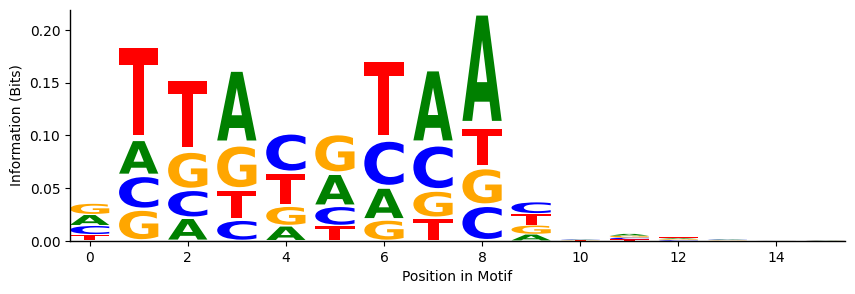

In [104]:
fig, ax = plt.subplots(figsize=(10, 3))
    
logo = logomaker.Logo(info_df,
                      ax=ax,
                      color_scheme='classic',
                      vpad=.1,
                      width=.8)

logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
ax.set_ylabel("Information (Bits)")
ax.set_xlabel("Position in Motif")
#ax.set_ylim([0, 2])

plt.show()